<a href="https://colab.research.google.com/github/AV-BOLT/yandex_practicum/blob/master/yandex_diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[**Ссылка на colab**](#https://colab.research.google.com/drive/120P6HOVM4AORAgbFs0r4b1NvlMXoeGxN?usp=sharing)

#Телеком

## Описание проекта


Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов:
  - через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия»)
  - оптоволоконный кабель (англ. fiber optic).
- Интернет-безопасность:
   - антивирус (Device Protection)
   - блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV)
- каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.
Информация о договорах актуальна на 1 февраля 2020.

Данная задача прогнозирования оттока пользователей является задачей бинарной классификации.
Для решения задачи нам необходимо подготовить данные:
- Загрузить все таблицы из базы даных с помощью подключения sql
- проанализировать таблицы на предмет полноты, пропусков
- объединить все таблицы
- проанализировать признаки на информативность
- Подготовить признаки для машинного обучения (перевести категориальные признаки в числовые, масштабировать числовые признаки).

**Машинное обучение**

Нам необходимо оптимизировать метрику auc score, которая согласно заданию на проект должна достигать минимального значения 0.85.

В задании имеется требование к используемым моделям, так, нам необходимо использовать модели основанные на алгоритме решающего дерева и градиентного бустинга, а также нейронную сеть.

Поэтому я буду использовать
- RandomForest
- CatBoost
- LightGbm
- Полносвязную нейронную сеть с дропаут.

Для моделей RandomForest, CatBoost, LightGbm будем подбирать гиперпараметры с помощью фреймворка Оптуна и grid_search_cv.



## Импорты и загрузка данных

In [ ]:
import pandas as pd
#!pip install -- upgrade pandas

import numpy as np
import datetime
import time
from itertools import product

import warnings# мы будем игнорировать warnings
warnings.filterwarnings(action = 'ignore', category = Warning)

from tqdm.autonotebook import tqdm
tqdm.pandas()

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import matplotlib
matplotlib.rcParams['font.size'] = 13
!python3 -mpip install matplotlib -q

# sklearn
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score,precision_recall_curve, RocCurveDisplay
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score

# модельки

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier

import warnings
warnings.filterwarnings("ignore")

import torch
#from torch import nn
import  torch.nn  as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

!pip install catboost -q
!pip install --upgrade catboost -q
import catboost
from catboost import  Pool, CatBoostClassifier

!pip install lightgbm -q
import lightgbm as lgb

!pip install optuna -q
import optuna

# только для этой версии работает подключение
!pip install SQLAlchemy==1.4.25

# Import necessary libraries
from sqlalchemy import create_engine

%pip install --upgrade matplotlib -q

In [ ]:
# зафиксируем параметр случайности
RANDOM_STATE = 11122023
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
}

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [ ]:
engine = create_engine(connection_string)

**Проверяем наличие и содержание таблиц**

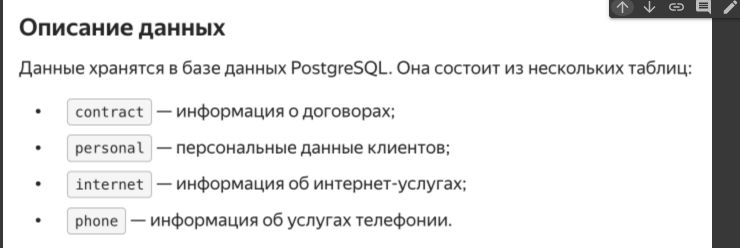

####contract

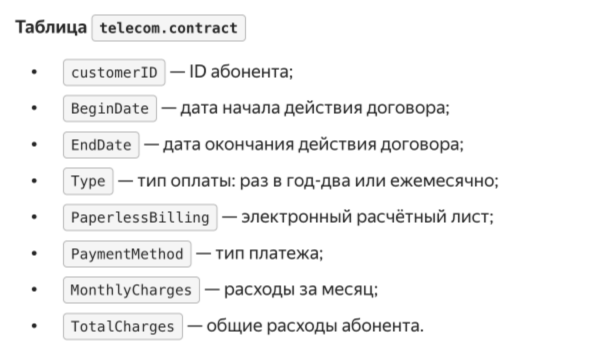

In [ ]:
# проверим
query = '''
SELECT *
FROM telecom.contract;
'''
example = pd.read_sql_query(query, con = engine)
example.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Все столбцы имеются

#### personal

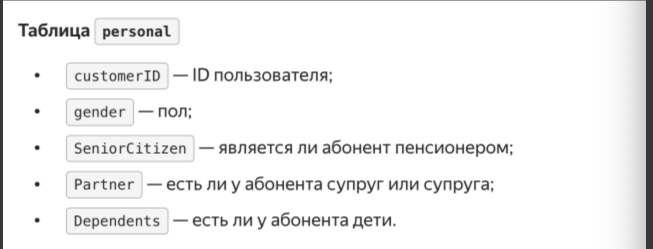

In [ ]:
# сохраним датасет
query = '''
SELECT *
FROM telecom.personal;
'''
example = pd.read_sql_query(query, con = engine)
example.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
2610,5202-IVJNU,Female,0,No,Yes
6699,3662-FXJFO,Female,0,No,No
586,4568-KNYWR,Male,0,No,No
1514,5799-JRCZO,Female,0,No,Yes
5476,6060-DRTNL,Female,1,No,No


In [ ]:
example.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [ ]:
example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


####internet

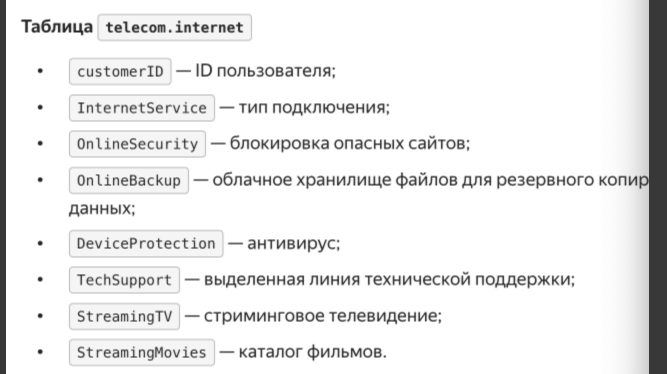

In [ ]:
# сохраним датасет
query = '''
SELECT *
FROM telecom.internet
;
'''
example = pd.read_sql_query(query, con = engine)
example.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [ ]:
example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


В этом датасете на 1525 наблюдений меньше чем в других

Названия столбцов съехали вниз и теперь они отображены как значения.
- Можно либо объединить это так, имея в виду что с1 это 	customerID

####phone

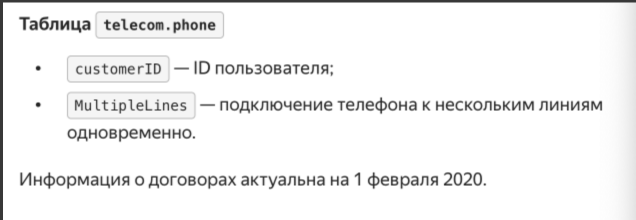

In [ ]:
# сохраним датасет
query = '''
SELECT *
FROM telecom.phone;
'''
example = pd.read_sql_query(query, con = engine)
example.head(5)

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


In [ ]:
example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


в данной таблице так же названия съехали вниз и количество объектов не совппадает с предыдущими

In [ ]:
example['c1'].duplicated().sum()

0

### **Создаем датасет**

- Все таблицы имеют общий столбец customerID, кроме таблиц internet и phone,
- в данных содержится разное количество объектов поэтому объединять будем так чтобы в общую таблицу попали объекты которые есть во всех таблицах

In [ ]:
query = '''
SELECT *
FROM telecom.contract as tc

LEFT JOIN telecom.personal AS tp ON tc."customerID" = tp."customerID"

INNER JOIN telecom.internet AS ti ON tc."customerID" = ti."c1"

INNER JOIN telecom.phone AS tph ON tc."customerID" = tph."c1";
'''

data = pd.read_sql_query(query, con = engine)
data.head(5)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,customerID,gender,...,c1,c2,c3,c4,c5,c6,c7,c8,c1,c2
0,5575-GNVDE,2019-03-26,None,One year,No,Mailed check,56.95,1889.50,5575-GNVDE,Male,...,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,5575-GNVDE,No
1,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,3668-QPYBK,Male,...,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,3668-QPYBK,No
2,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,9237-HQITU,Female,...,9237-HQITU,Fiber optic,No,No,No,No,No,No,9237-HQITU,No
3,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,9305-CDSKC,Female,...,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes,9305-CDSKC,Yes
4,1452-KIOVK,2018-12-20,None,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,1452-KIOVK,Male,...,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No,1452-KIOVK,Yes


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           1586 non-null   object 
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   object 
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4832 non-null   float64
 8   customerID        4835 non-null   object 
 9   gender            4835 non-null   object 
 10  SeniorCitizen     4835 non-null   int64  
 11  Partner           4835 non-null   object 
 12  Dependents        4835 non-null   object 
 13  c1                4835 non-null   object 
 14  c2                4835 non-null   object 
 15  c3                4835 non-null   object 
 16  c4                4835 non-null   object 


- В данных имееюся пропуски.
- Названия признаков записаны в camel формате, необходимо заменить на snacke_case для удобства
- имеются признаки с неинформативными названиями (с1, с2 и тд)
- в итоговом датасете осталось почти на 3000 объектов меньше чем в исходном

In [ ]:
# 1 таблицу мы присоединили internet, поэтому сохраним названия
internet = ['customerID', 'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',	'TechSupport',	'StreamingTV',	'StreamingMovies']


In [ ]:
# 2 таблицу мы присоединили phone, поэтому сохраним названия
phone = ['customerID', 'MultipleLines']


In [ ]:
# сохраним список названий признаков
columns = data.columns.to_list()


In [ ]:
# привидем к строчному регистру
new_columns = (columns + internet + phone)

list(map(lambda x: x.lower(), new_columns))

['customerid',
 'begindate',
 'enddate',
 'type',
 'paperlessbilling',
 'paymentmethod',
 'monthlycharges',
 'totalcharges',
 'customerid',
 'gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'c1',
 'c2',
 'customerid',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'customerid',
 'multiplelines']

In [ ]:
# добавим разделитель и отметим дублирующиеся
columns = [
    'customer_id',
    'begin_date',
    'end_date',
    'type',
    'paperless_billing',
    'payment_method',
    'monthly_charges',
    'total_charges',
    'customer_id1',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'customer_id2',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'customer_id3',
    'multiple_lines']

In [ ]:
# сохраним новые названия признаков
data.columns = columns
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,customer_id1,gender,...,customer_id2,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,customer_id3,multiple_lines
0,5575-GNVDE,2019-03-26,None,One year,No,Mailed check,56.95,1889.50,5575-GNVDE,Male,...,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,5575-GNVDE,No
1,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,3668-QPYBK,Male,...,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,3668-QPYBK,No
2,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,9237-HQITU,Female,...,9237-HQITU,Fiber optic,No,No,No,No,No,No,9237-HQITU,No
3,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,9305-CDSKC,Female,...,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes,9305-CDSKC,Yes
4,1452-KIOVK,2018-12-20,None,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,1452-KIOVK,Male,...,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No,1452-KIOVK,Yes


In [ ]:
# удалим  признаки связанные с id клиентов
data.drop(['customer_id', 'customer_id1', 'customer_id2', 'customer_id3'], axis = 1, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         4835 non-null   object 
 1   end_date           1586 non-null   object 
 2   type               4835 non-null   object 
 3   paperless_billing  4835 non-null   object 
 4   payment_method     4835 non-null   object 
 5   monthly_charges    4835 non-null   float64
 6   total_charges      4832 non-null   float64
 7   gender             4835 non-null   object 
 8   senior_citizen     4835 non-null   int64  
 9   partner            4835 non-null   object 
 10  dependents         4835 non-null   object 
 11  internet_service   4835 non-null   object 
 12  online_security    4835 non-null   object 
 13  online_backup      4835 non-null   object 
 14  device_protection  4835 non-null   object 
 15  tech_support       4835 non-null   object 
 16  streaming_tv       4835 

Исходные данные имеют размерность 4835 объекта объекта, 20 признак.

- данные имеют пропуски
- названия признаков перезаписаны в snake_case (изначально были в camel case)
- имеются категориальные и числовые признаки
- вероятно булев тип значений представлен в виде категорий.

## Исследовательский анализ и предобработка данных

##### Типы данных

In [ ]:
# оценим типы данных
data.dtypes

begin_date            object
end_date              object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
gender                object
senior_citizen         int64
partner               object
dependents            object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
multiple_lines        object
dtype: object

- begin_date, object нужно перевести в
pd.datetime
- end_date (object) нужно перевести в
pd.datetime

In [ ]:
# заменим на тип данных date
data[['begin_date', 'end_date']] = data[['begin_date', 'end_date']]\
       .apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d', errors = 'coerce'))


In [ ]:
data[['begin_date', 'end_date']]

,begin_date,end_date
0,2019-03-26,NaT
1,2018-08-09,2019-12-01
2,2019-01-26,2019-11-01
3,2018-12-26,2019-11-01
4,2018-12-20,NaT
...,...,...
4830,2019-06-07,NaT
4831,2019-02-26,NaT
4832,2019-09-02,NaT
4833,2018-12-07,2019-11-01


##### Дупликаты

In [ ]:
# проверим дупликаты
data.duplicated(keep = False).sum()

0

Дупликатов нет

##### Пропуски

In [ ]:
# отобразим пропущенные значения
data.isna().sum()

begin_date              0
end_date             3249
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           3
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
dtype: int64

Пропусков у нас совсем незначительное количество в признаке total_charges, а в признаке end_date это очевидно объекты для которых нет такой даты

In [ ]:
# оценим объекты с пропусками
data.loc[data['total_charges'].isna()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
663,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4573,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes
4630,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.90,NaN,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Yes


Для клиентов кто только начал пользоваться услугами компании (так как база заканачивается февралем 20 года)total_charges обратился в Nan, заменим на значение 0, так как вероятнее всего это рассчитывается как произведение периода на сумму месячных затрат и ставить на место этих пропусков значение из признакак monthly_charges может не соответствовать логике



In [ ]:
#  заполняем 0
data.loc[data['total_charges'].isna(), 'total_charges'] = 0

In [ ]:
# проверяем
data.isna().sum()

begin_date              0
end_date             3249
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
dtype: int64

Проанализируем целевой признак

In [ ]:
# создадим новый признак churn на основе end_date
data['churn'] = 1
data.loc[data['end_date'].isna(), 'churn'] = 0
data[['end_date', 'churn']]

,end_date,churn
0,NaT,0
1,2019-12-01,1
2,2019-11-01,1
3,2019-11-01,1
4,NaT,0
...,...,...
4830,NaT,0
4831,NaT,0
4832,NaT,0
4833,2019-11-01,1


Далее будем анализировать отдельно категориальные и отдельно числовые, для этого создадим функцию для отбора признаков по типу

In [ ]:
# добавим функцию для выделения типа признаков

#отбирает категориальные
def is_categorical(data):
    return data.select_dtypes(include = 'object').columns.to_list()

#отбирает числовые
def is_numeric(data):
    return data.select_dtypes(exclude = 'object').columns.to_list()

#### Анализ категориальных

In [ ]:
# создаем список категориальных
categorical = is_categorical(data)

In [ ]:
# оценим что содержат в себе эти данные
data[categorical].head()

,type,paperless_billing,payment_method,gender,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,One year,No,Mailed check,Male,No,No,DSL,Yes,No,Yes,No,No,No,No
1,Month-to-month,Yes,Mailed check,Male,No,No,DSL,Yes,Yes,No,No,No,No,No
2,Month-to-month,Yes,Electronic check,Female,No,No,Fiber optic,No,No,No,No,No,No,No
3,Month-to-month,Yes,Electronic check,Female,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,Month-to-month,Yes,Credit card (automatic),Male,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes


Много признаков вероятнее всего имеют булев тип. Такие признаки переведем в числовые, для удобства анализа. Для этого мы сохраним их в список to_bool с помощью цикла.
Отбирать будем по условию, что содержит всего 2 уникальных значения

In [ ]:
is_bool = []
# найдем булевы типы
for col in categorical:
    if data[col].nunique() == 2:
        is_bool.append(col)
# выведем получившийся список
is_bool

['paperless_billing',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

Признаки отобраны, теперь проанализируем их и затем изменим тип данных на числовой.

In [ ]:
# сгруппируем по целевому признаку
for col in is_bool:
    print(data.groupby(col)['churn'].mean())
    print()


paperless_billing
No     0.231129
Yes    0.371480
Name: churn, dtype: float64

gender
Female    0.333195
Male      0.322887
Name: churn, dtype: float64

partner
No     0.405721
Yes    0.246069
Name: churn, dtype: float64

dependents
No     0.366816
Yes    0.218081
Name: churn, dtype: float64

internet_service
DSL            0.166187
Fiber optic    0.418928
Name: churn, dtype: float64

online_security
No     0.425944
Yes    0.153226
Name: churn, dtype: float64

online_backup
No     0.413665
Yes    0.220355
Name: churn, dtype: float64

device_protection
No     0.401030
Yes    0.234294
Name: churn, dtype: float64

tech_support
No     0.423377
Yes    0.160684
Name: churn, dtype: float64

streaming_tv
No     0.346457
Yes    0.309661
Name: churn, dtype: float64

streaming_movies
No     0.349854
Yes    0.306491
Name: churn, dtype: float64

multiple_lines
No     0.338169
Yes    0.319513
Name: churn, dtype: float64



In [ ]:
# преобразуем признаки internet_service и gender с помощью dummy
data = pd.get_dummies(data,
                      columns = ['internet_service', 'gender'],
                      drop_first = False)
data.head()


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,internet_service_DSL,internet_service_Fiber optic,gender_Female,gender_Male
0,2019-03-26,NaT,One year,No,Mailed check,56.95,1889.50,0,No,No,...,Yes,No,No,No,No,0,1,0,0,1
1,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0,No,No,...,No,No,No,No,No,1,1,0,0,1
2,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,0,No,No,...,No,No,No,No,No,1,0,1,1,0
3,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,0,No,No,...,Yes,No,Yes,Yes,Yes,1,0,1,1,0
4,2018-12-20,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,No,Yes,...,No,No,Yes,No,Yes,0,0,1,0,1


In [ ]:
# Приведем к типу 0/1 для удобства анализа
data[['internet_service_DSL', 'internet_service_Fiber optic', 'gender_Female','gender_Male']] = \
data[['internet_service_DSL', 'internet_service_Fiber optic', 'gender_Female','gender_Male']].astype('int')

In [ ]:
# пересоберем
is_bool = []

# найдем булевы типы
for col in is_categorical(data):
    if data[col].nunique() == 2:
        is_bool.append(col)
# выведем получившийся список
is_bool

['paperless_billing',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

Теперь можно заменить на 0 и 1 оставшиеся признаки

In [ ]:
# заменим значения yes/no на 0 и 1
data[is_bool] = data[is_bool].applymap(lambda x: 1 if (x == 'Yes') else 0)

In [ ]:
data[is_bool]

,paperless_billing,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,0,0,0,1,0,1,0,0,0,0
1,1,0,0,1,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,1,1,1
4,1,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
4830,1,0,0,0,0,0,0,1,0,0
4831,1,1,1,1,0,1,1,1,1,1
4832,1,1,1,0,1,1,0,1,1,1
4833,1,1,0,0,0,0,0,0,0,1


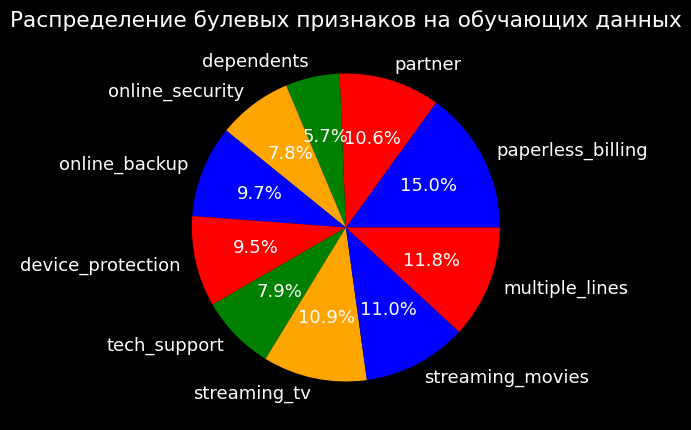

In [ ]:
#Визуализируем булевые признаки на круговой диаграмме
colors = ['blue', 'red', 'green', 'orange']
count_true = [data[col].sum() for col in is_bool]# считаем единицы

#  круговая диаграмма для булевых признаков
plt.figure(figsize = (5,5))
plt.pie(count_true,
        autopct = "%1.1f%%",
        labels = is_bool,
        colors = colors)

plt.title('Распределение булевых признаков на обучающих данных')
plt.show()

Видим, что признаки несбалансированы, нужно будет разделять выборки с учетом дисбаланса

In [ ]:
# оценим оставшиеся категориальные признаки
data[is_categorical(data)]

,type,payment_method
0,One year,Mailed check
1,Month-to-month,Mailed check
2,Month-to-month,Electronic check
3,Month-to-month,Electronic check
4,Month-to-month,Credit card (automatic)
...,...,...
4830,Month-to-month,Bank transfer (automatic)
4831,One year,Mailed check
4832,One year,Credit card (automatic)
4833,Month-to-month,Mailed check


In [ ]:
# оценим уникальные в оставшихся признаках
print(data[is_categorical(data)].nunique())

type              3
payment_method    4
dtype: int64


In [ ]:
type_pivot = pd.pivot_table(data[['type', 'churn']],
               columns = 'type',
               index = 'churn',
               aggfunc = 'size')
type_pivot

type,Month-to-month,One year,Two year
churn,,,
0,1572,821,856
1,1403,143,40


Оставшиеся категориальные переменные закодируем с помощью label encoder после разделения выборки на train valid чтобы избежать утечки данных.


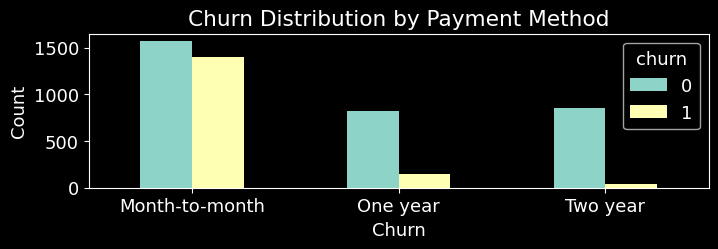

In [ ]:
# Построим столбчатые диаграммы
fig, ax = plt.subplots(figsize=(8, 2))

type_pivot.T.plot(kind = 'bar', stacked = False, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)  # Поворачиваем подписи оси x
ax.set_title('Churn Distribution by Payment Method')
ax.set_ylabel('Count')
ax.set_xlabel('Churn')

plt.show()

Видим что самый высокий уровень оттока для клиентов кто оплачивает счет по факту (month to month), по сравнению с теми кто платит авансом

In [ ]:
# сгруппируем данные по способу платежа
method_pivot = pd.pivot_table(data[['payment_method', 'churn']],
               columns = 'payment_method',
               index = 'churn',
               aggfunc = 'size')
method_pivot

payment_method,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
churn,,,,
0,850,833,1057,509
1,219,204,960,203


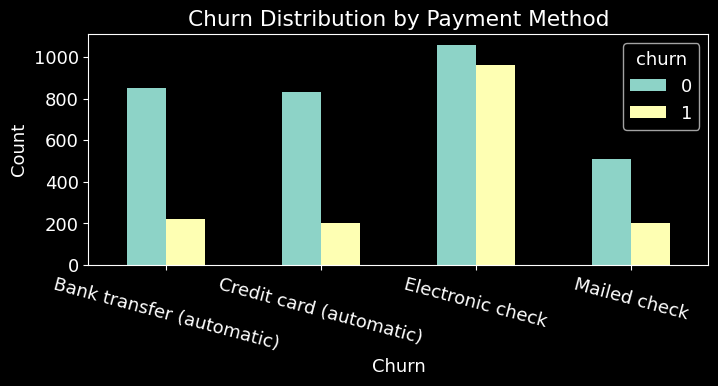

In [ ]:
# Построим столбчатые диаграммы
fig, ax = plt.subplots(figsize=(8, 3))

method_pivot.T.plot(kind = 'bar', stacked = False, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = -15)  # Поворачиваем подписи оси x
ax.set_title('Churn Distribution by Payment Method')
ax.set_ylabel('Count')
ax.set_xlabel('Churn')

plt.show()

Видим что почти для всех категорий уровень оттока клиентов одинаковый, только в категории electronic check примерно одинаковый уровень оттока, что учитывая дисбаланс классов говорит о том, что чаще уходят клиенты, c типом оплаты electronic check

In [ ]:
is_categorical(data)

['type', 'payment_method']

Категориальных признаков осталось всего 2: type, payment_method. Они включают в себя 3 и 4 уникальных категорий соответственно, кодировать их в числовые будем далее, после разбиения выборки.

### Анализ числовых

In [ ]:
is_numeric(data)

['begin_date',
 'end_date',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'senior_citizen',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'churn',
 'internet_service_DSL',
 'internet_service_Fiber optic',
 'gender_Female',
 'gender_Male']

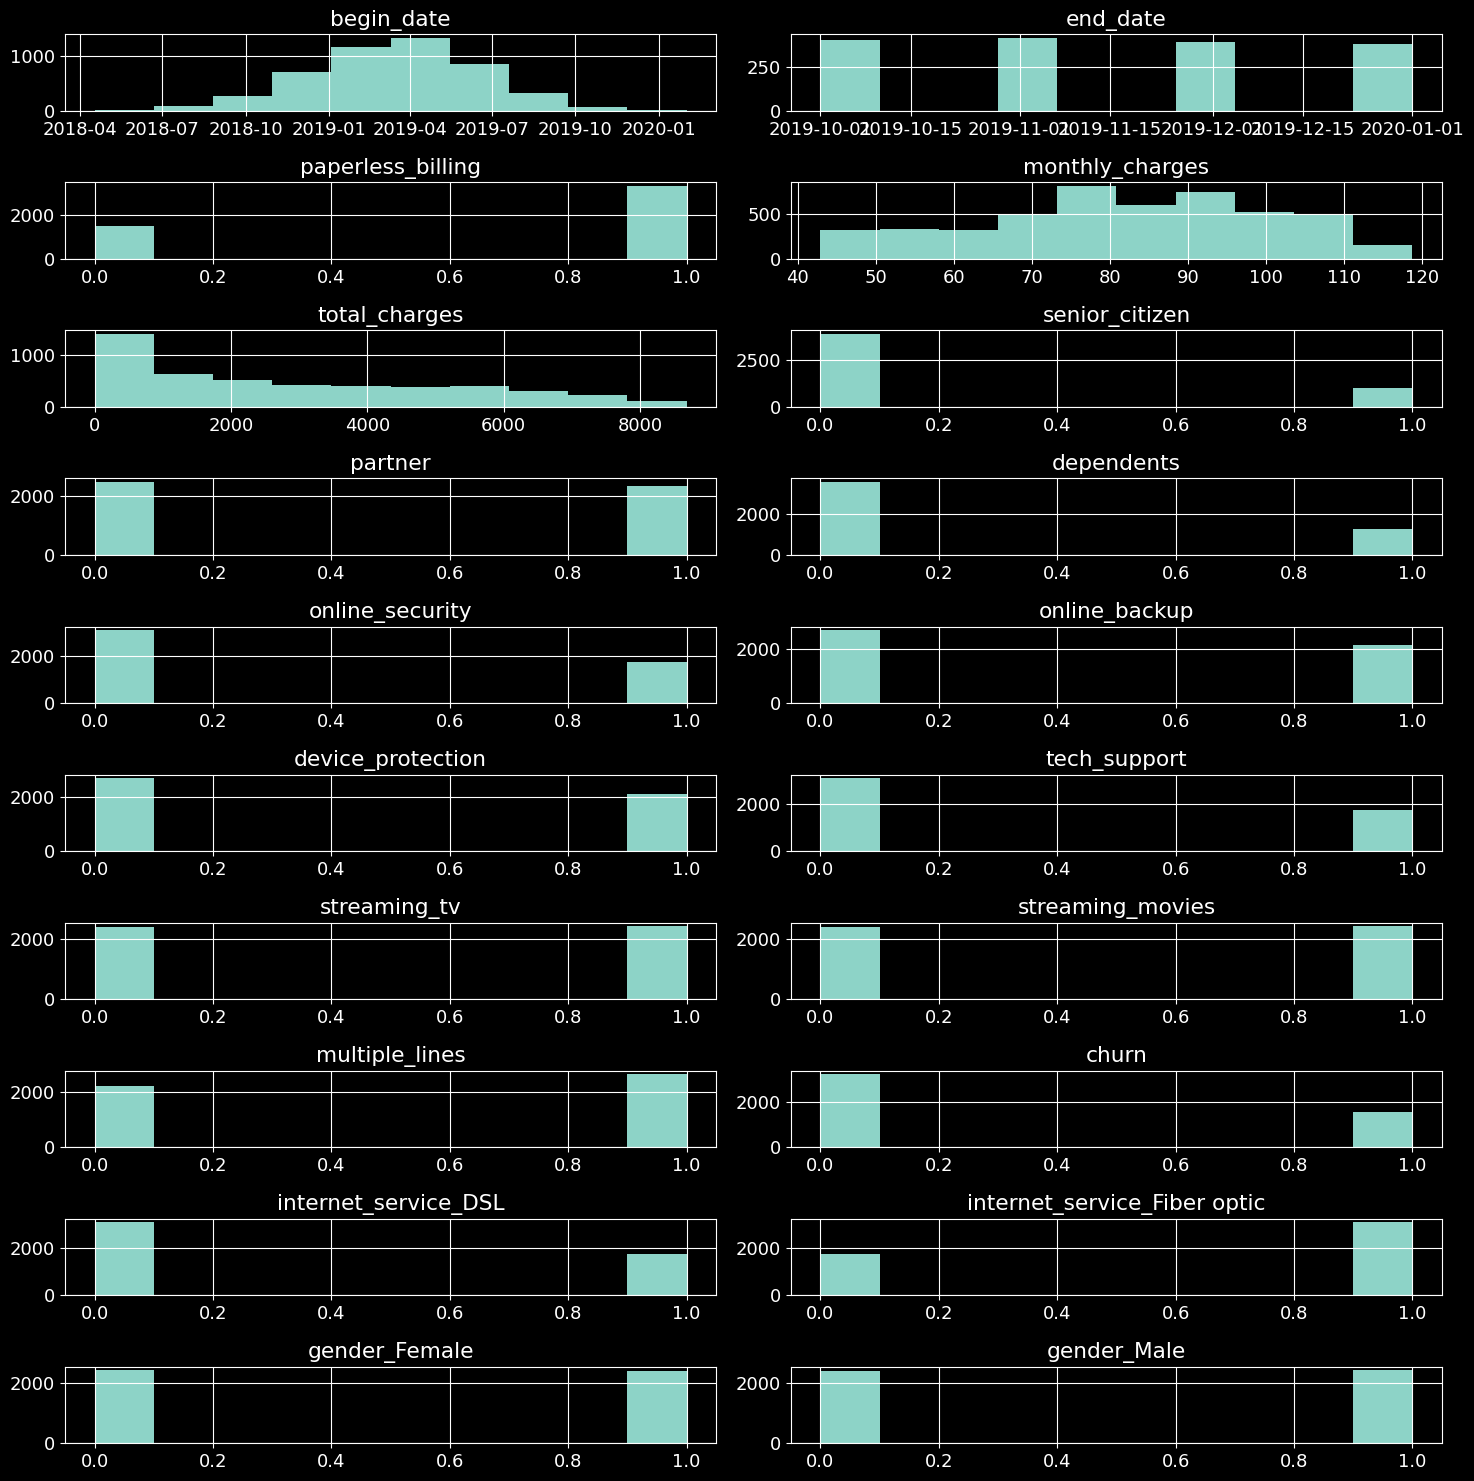

In [ ]:
# отобразим все числовые на графиках

data[is_numeric(data)].hist(layout = (10,2),figsize = (15, 15))

plt.tight_layout();

Видим, что:
- почти все числовые признаки представлены в виде бинарных значений.
- 2 признака представлены в виде даты
- 2 признака это непрерывные пременные отржажающие сумму трат помесячно и годовое значение суммы трат.
Учитывая что для бинарных переменных мы можем оценить только сбалансированность, будем анализировать оставшиеся признаки на выбросы.
Так же необходимо проверить наличие линейной зависимости с целевой переменной в данных.

In [ ]:
# отобразим диапазон дат для признака begin_date
print(f'''
Самая ранняя дата договора: {data[['begin_date']].min()}

Самая поздняя дата договора: {data[['begin_date']].max()}''')


Самая ранняя дата договора: begin_date   2018-04-17
dtype: datetime64[ns]

Самая поздняя дата договора: begin_date   2020-02-01
dtype: datetime64[ns]


In [ ]:
 data['end_date'] - data['begin_date']

0           NaT
1      479 days
2      279 days
3      310 days
4           NaT
         ...   
4830        NaT
4831        NaT
4832        NaT
4833   329 days
4834        NaT
Length: 4835, dtype: timedelta64[ns]

In [ ]:
# заменим пропуски последней датой актуализации базы
data.loc[data['end_date'].isna(), 'end_date'] = \
data.loc[data['end_date'].isna(), 'end_date'].fillna('2020-02-01')

In [ ]:
# добавим новый признак
data['client_period'] =  (data['end_date'] - data['begin_date']).dt.days
data['client_period'].head()

0    312
1    479
2    279
3    310
4    408
Name: client_period, dtype: int64

На основе признака  end_date и begin_date  мы создали новые признаки:
-  целевой признак
- продолжительность жизни клиента в днях.
Поэтому  мы удалим признаки с датой


In [ ]:
data.drop(['begin_date', 'end_date'], axis = 1, inplace = True)

Посмотрим на значения в признаках 'monthly_charges, 'total_charges' чтобы выяснить не являются ли они дублирующими или линейно зависимыми

In [ ]:
data[['monthly_charges', 'total_charges']]

,monthly_charges,total_charges
0,56.95,1889.50
1,53.85,108.15
2,70.70,151.65
3,99.65,820.50
4,89.10,1949.40
...,...,...
4830,78.70,1495.10
4831,84.80,1990.50
4832,103.20,7362.90
4833,74.40,306.60


In [ ]:
# проверим можно ли получить признак total_charges умножив период на сумму месячных расходов
np.allclose(np.array(data['total_charges']), \
            np.array((data['monthly_charges'] * data['client_period']/30)))


False

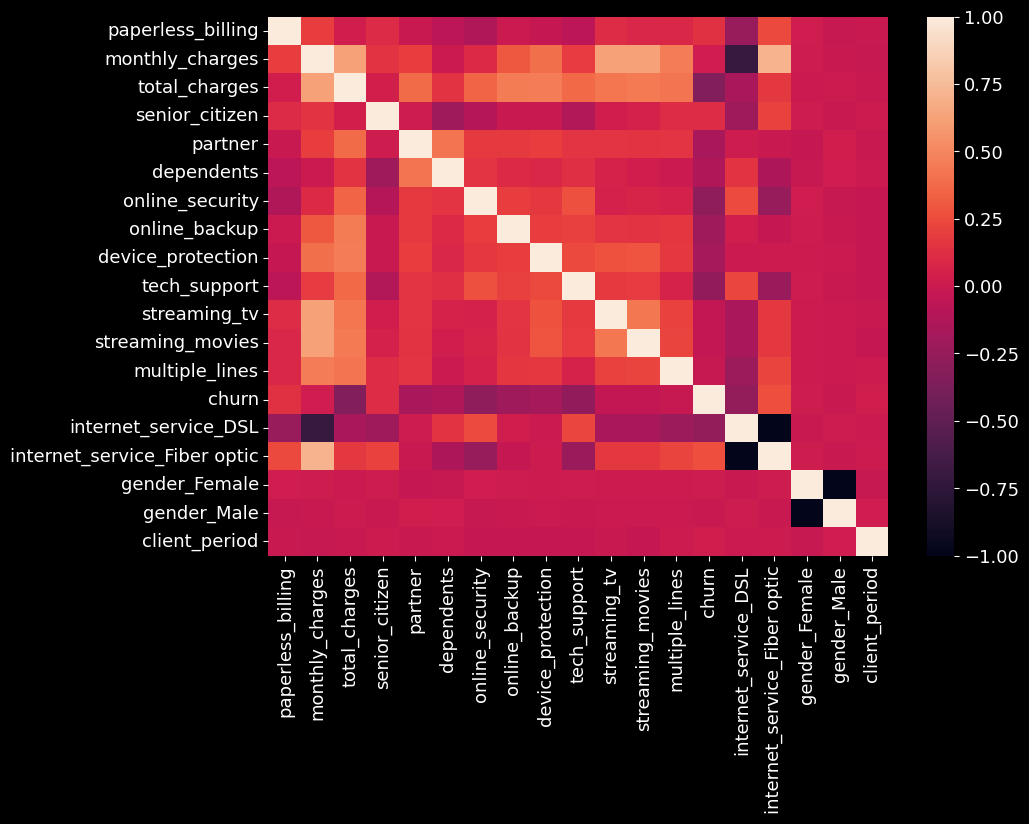

In [ ]:
# оценим корреляцию целевого признака с непрерывными признаками
corr = data[is_numeric].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values)
plt.show()

Наблюдаем сильную линейную зависимость между признаками, но она больше отражает зависимость между тратами и услугами клиента. На уход клиента предварительно влияет срок который он является пользователем услуг этой компании. То есть давние клиенты прояляют большую лояльность к компании.

**Оцении выбросы и аномалии**

,count,mean,std,min,25%,50%,75%,max
client_period,4835.0,297.148707,83.563069,0.0,242.0,297.0,351.0,583.0


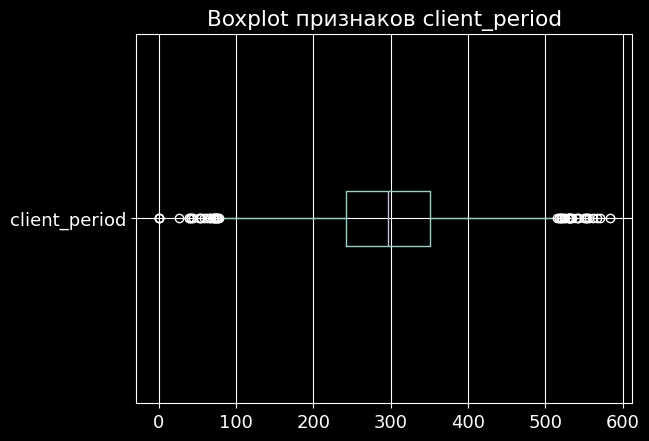

In [ ]:
data[['client_period']].boxplot(vert = False)
plt.title('Boxplot признаков client_period')
data[['client_period']].describe().transpose()

Отрицательных нет, значит с данными все нормально.
Видим что срок жизни клиентов для этой компании не очень велик, клиенты пользующиеся услугами компании дольше полутора лет уже редкость. В среднем люди пользуются их услугами один год

,count,mean,std,min,25%,50%,75%,max
monthly_charges,4835.0,81.755171,18.303085,42.9,69.775,82.5,95.7,118.75


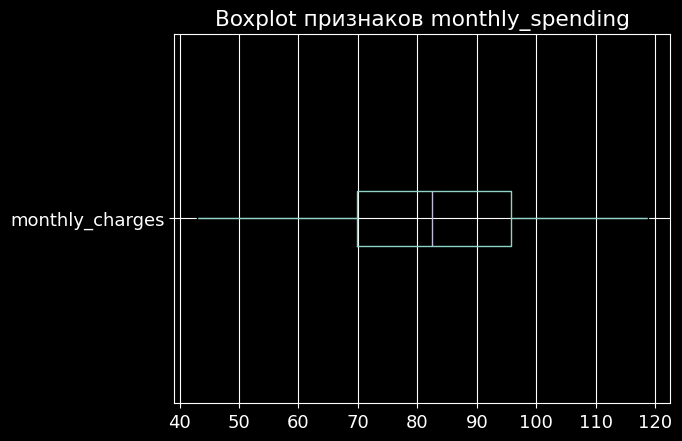

In [ ]:
data[['monthly_charges']].boxplot(vert = False)
plt.title('Boxplot признаков monthly_spending');
data[['monthly_charges']].describe().transpose()

Вообще нет выбросов и редких значений

,count,mean,std,min,25%,50%,75%,max
total_charges,4835.0,2900.669876,2415.896065,0.0,658.725,2347.9,4870.275,8684.8


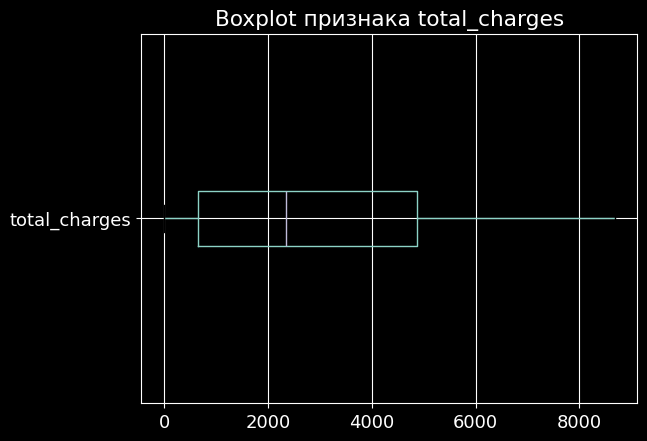

In [ ]:
data[['total_charges']].boxplot(vert = False)
plt.title('Boxplot признака total_charges')
data[['total_charges']].describe().transpose()

Выбросов нет, но есть большой разброс значений, так стандартное отклонение 2415 при среднем 2347 может говорить о том, что потребление услуг очень неравномерно.

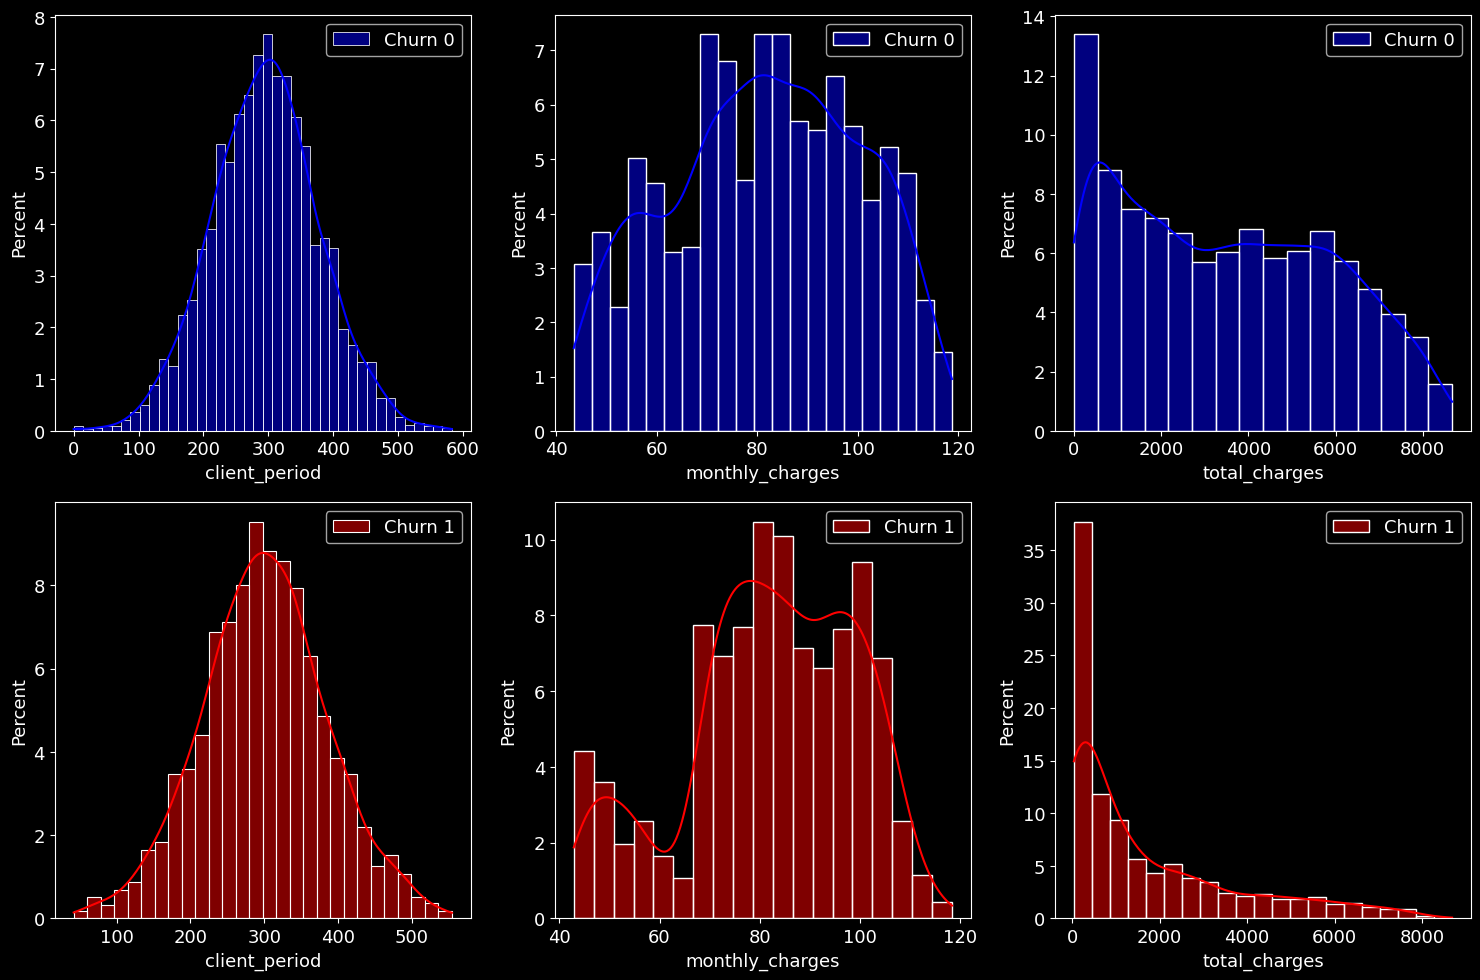

In [ ]:
# Выбираем только строки с churn = 0
to_plot = data[['client_period', 'monthly_charges', 'total_charges', 'churn']]
churn_0 = to_plot[to_plot['churn'] == 0]

# Выбираем только строки с churn = 1
churn_1 = to_plot[to_plot['churn'] == 1]

#
n_rows = 2
n_cols = 3 # Рассматриваем только непрерывные признаки


fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

#  графики для каждого признака
for i, feature in enumerate(['client_period', 'monthly_charges', 'total_charges']):
    # Гистограммы для признака
    sns.histplot(data = churn_0,
                 x = feature,
                 kde=True,
                 ax=axes[0, i],
                 color='blue',
                 label='Churn 0',
                 stat='percent')
    sns.histplot(data = churn_1,
                 x = feature,
                 kde=True,
                 ax=axes[1, i],
                 color='red',
                 label='Churn 1',
                 stat='percent')
    axes[0, i].legend()
    axes[1, i].legend()

plt.tight_layout()
plt.show()


На графиках видим, что тип распределения меняется для признака 'client_period', основная часть клиентов уходит до 10 месяца, а дальше уменьшается постепенно. После 15 мес клиенты редко уходят.

Те кто ушел значительно больше тратили ежемесячно, что противоречит тем кто остался:те кто остался в большинстве тратят меньше (20$)

А ушедшие клиенты наоборот тратили больше (65-105$)

## Машинное обучение

In [ ]:
is_bool = []
# найдем булевы типы
for col in data.columns:
    if data[col].nunique() == 2:
        is_bool.append(col)
# выведем получившийся список
data[is_bool].mean().sort_values()

senior_citizen                  0.203930
dependents                      0.260807
churn                           0.328025
online_security                 0.359049
internet_service_DSL            0.359669
tech_support                    0.362978
device_protection               0.437849
online_backup                   0.443020
partner                         0.486660
gender_Female                   0.498449
streaming_tv                    0.500931
gender_Male                     0.501551
streaming_movies                0.503413
multiple_lines                  0.543744
internet_service_Fiber optic    0.640331
paperless_billing               0.690383
dtype: float64

Данные несбалансированы по нескольким признакам, senior_citizen, dependents и целевой признак churn. Попробуем разделить выборку по с учетом всех этих признаков

In [ ]:
#разделим выборку
train, valid = train_test_split(data,
                                shuffle = True,
                                stratify = data[['churn', 'senior_citizen', 'dependents']],
                                test_size = 0.15,
                                random_state = RANDOM_STATE)

#выделим тестовую выборку из обучающей
train, test = train_test_split(train,
                               shuffle = True,
                               stratify = train[['churn']],
                               test_size = 0.15,
                               random_state = RANDOM_STATE)

print (f'''
Размер обучающей выборки {train.shape}

Размер валидационной выборки {valid.shape}

Размер тестовой выборки {test.shape}

''')


Размер обучающей выборки (3492, 21)

Размер валидационной выборки (726, 21)

Размер тестовой выборки (617, 21)




**Кодирование категориальных**

In [ ]:
train[is_categorical(train)].columns

Index(['type', 'payment_method'], dtype='object')

In [ ]:
# Рассчитаем среднее значение таргета для каждой категории на train
mean_type_map = train.groupby(['type'])['churn'].mean()
mean_type_map

type
Month-to-month    0.478363
One year          0.143662
Two year          0.041159
Name: churn, dtype: float64

In [ ]:
# кодируем
train['type_enc'] = train['type'].map(mean_type_map)
# проверяем
train[['type','type_enc']].sample(5)

,type,type_enc
1916,Two year,0.041159
640,Month-to-month,0.478363
3386,Two year,0.041159
985,Month-to-month,0.478363
1858,Month-to-month,0.478363


In [ ]:
# Рассчитаем среднее значение таргета для каждой категории на train
# в признаке payment_method
mean_method_map = train.groupby(['payment_method'])['churn'].mean()
mean_method_map

payment_method
Bank transfer (automatic)    0.203871
Credit card (automatic)      0.204427
Electronic check             0.481145
Mailed check                 0.274662
Name: churn, dtype: float64

In [ ]:
# кодируем
train['payment_method_enc'] = train['payment_method'].map(mean_method_map)
# проверяем
train[['payment_method_enc','payment_method']].sample(5)

,payment_method_enc,payment_method
390,0.203871,Bank transfer (automatic)
2647,0.481145,Electronic check
3450,0.274662,Mailed check
4715,0.203871,Bank transfer (automatic)
1093,0.203871,Bank transfer (automatic)


In [ ]:
# Заменяем значения в val test средними значениями из train
valid['payment_method_enc'] = valid['payment_method'].map(mean_method_map)
valid['type_enc'] = valid['type'].map(mean_type_map)

test['payment_method_enc'] = test['payment_method'].map(mean_method_map)
test['type_enc'] = test['type'].map(mean_type_map)

In [ ]:
# удаляем исходные признаки
train.drop(['type', 'payment_method'], axis = 1, inplace = True)
valid.drop(['type', 'payment_method'], axis = 1, inplace = True)
test.drop(['type', 'payment_method'], axis = 1, inplace = True)

**Масштабируем признаки**

In [ ]:
# выделим обучающие и целевые признаки
X = train.drop('churn', axis = 1).columns.to_list()
y = 'churn'

In [ ]:
# инициируем скалер
scaler = StandardScaler()

In [ ]:
#Масштабируем признаки
train[X] = scaler.fit_transform(train[X])
valid[X] = scaler.transform(valid[X])
test[X] = scaler.transform(test[X])

train[X].head()

,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet_service_DSL,internet_service_Fiber optic,gender_Female,gender_Male,client_period,type_enc,payment_method_enc
2539,0.661982,-0.643630,0.319251,-0.505185,1.00632,-0.59852,-0.748081,-0.895984,-0.884614,-0.763515,0.982400,0.989743,0.9122,1.337586,-1.337586,1.010363,-1.010363,0.608795,-0.970732,-0.954282
3990,0.661982,1.515296,2.066399,1.979472,1.00632,-0.59852,-0.748081,1.116091,1.130436,1.309731,0.982400,0.989743,0.9122,-0.747615,0.747615,-0.989743,0.989743,0.016087,-1.509997,-0.958571
3306,0.661982,-0.384668,-0.118359,1.979472,-0.99372,-0.59852,-0.748081,-0.895984,-0.884614,-0.763515,-1.017915,-1.010363,0.9122,-0.747615,0.747615,1.010363,-1.010363,0.560411,0.790112,-0.958571
4266,0.661982,0.888335,-0.987966,1.979472,-0.99372,-0.59852,-0.748081,1.116091,-0.884614,-0.763515,0.982400,0.989743,0.9122,-0.747615,0.747615,1.010363,-1.010363,-1.399156,0.790112,1.179567
3535,0.661982,1.883295,1.424216,1.979472,-0.99372,-0.59852,1.336754,1.116091,1.130436,1.309731,0.982400,0.989743,0.9122,-0.747615,0.747615,-0.989743,0.989743,-0.419373,0.790112,1.179567


Признаки для машинного обучения готовы, можно обучать модель.

In [ ]:
# Сохраним списки для сбора результатов работы моделей
auc_scores = []
models = []

In [ ]:
#функция для визуализации матрицы ошибок
def ConfMatrix(model):
    model_name = model.__class__.__name__
    model.fit(train[X],train[y])
    ConfusionMatrixDisplay.from_estimator(model, valid[X], valid[y])
    plt.title(f'''Матрица ошибок модели { model_name}''')
    plt.show()

In [ ]:
#функция для визуализации roc_auc
def AucDisp(list_model):

    #model_name = model.__class__.__name__
    disp = []

    ax = plt.gca()
    for cls in list_model:
        disp.append(RocCurveDisplay.from_estimator(cls,
                                                   valid[X],
                                                   valid[y],
                                                   ax = ax,
                                                   alpha = 0.8))

    #plot

    disp
    plt.title('ROC AUC всех моделей')

    plt.show()

### RandomForestClassifier

In [ ]:
# инициируем модель случайного леса
random_forest = RandomForestClassifier(class_weight = 'balanced',
                                       random_state = RANDOM_STATE)
random_forest.fit(train[X], train[y])

RandomForestClassifier(class_weight='balanced', random_state=11122023)

In [ ]:
# предсказания на дефолтных параметрах

scores = cross_val_score(random_forest,
                         train[X],
                         train[y],
                         cv = 5,
                         scoring = 'roc_auc')

score_RandomForest = scores.mean()

print (f'''
Среднее значение roc_auc для модели RandomForest: {score_RandomForest:0.4f}''')


Среднее значение roc_auc для модели RandomForest: 0.8031


Получили неплохое значение на дефолтных параметрах

In [ ]:
#добавляем результат

models.append('RandomForest(basic)')
auc_scores.append(score_RandomForest)

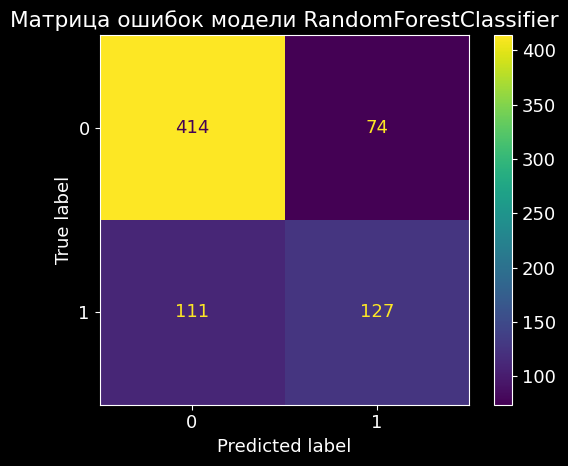

In [ ]:
ConfMatrix(RandomForestClassifier(class_weight = 'balanced',
                                  random_state =  RANDOM_STATE))

Видим, что модель плохо предсказывает редкий 1 класс

#### RandomizedSearchCV

In [ ]:
# создадим сетку для перебора
param_grid = (
    {'max_depth': np.arange(10, 100),
     'n_estimators': np.arange(50, 500),
     'max_features': ('sqrt', 'log2', None),
    'criterion': ('gini', 'entropy', 'log_loss'),
    'min_samples_leaf': np.arange(1, 100),
      'min_samples_split': range(2, 200)
    })

In [ ]:
#  инициализируем grid_search
grid_search = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = RANDOM_STATE, class_weight = 'balanced'),
                                 param_distributions = param_grid,
                                 cv = 3,
                                 n_iter = 15,
                                 verbose=1,
                                 random_state=RANDOM_STATE,
                                 n_jobs = -1,
                                 scoring = 'roc_auc'
                                 )

In [ ]:
# обучаем
%%time
grid_search.fit(train[X],  train[y])

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=11122023),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'criterion': ('gini', 'entropy',
                                                      'log_loss'),
                                        'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=11122023, scoring='roc_auc', verbose=1)

In [ ]:
# получаем лучшее значение метрики
grid_search.best_score_

0.8187981771356392

метрика улучшилась незначительно

In [ ]:
for params, std_test_score, mean_test_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['std_test_score'], grid_search.cv_results_['mean_test_score']):
    print("Параметры:", params)
    print("Стандартное отклонение (std) оценок:", std_test_score)
    print("Средняя оценка:", mean_test_score)
    print()

Параметры: {'n_estimators': 227, 'min_samples_split': 161, 'min_samples_leaf': 79, 'max_features': 'log2', 'max_depth': 28, 'criterion': 'entropy'}
Стандартное отклонение (std) оценок: 0.003437698863133271
Средняя оценка: 0.8143604129564413

Параметры: {'n_estimators': 235, 'min_samples_split': 126, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 83, 'criterion': 'entropy'}
Стандартное отклонение (std) оценок: 0.0029548236402253767
Средняя оценка: 0.8153524100284321

Параметры: {'n_estimators': 477, 'min_samples_split': 105, 'min_samples_leaf': 79, 'max_features': 'sqrt', 'max_depth': 94, 'criterion': 'log_loss'}
Стандартное отклонение (std) оценок: 0.003649771541127052
Средняя оценка: 0.8147838807728873

Параметры: {'n_estimators': 386, 'min_samples_split': 80, 'min_samples_leaf': 45, 'max_features': None, 'max_depth': 34, 'criterion': 'gini'}
Стандартное отклонение (std) оценок: 0.007433525046977086
Средняя оценка: 0.8187741862053266

Параметры: {'n_estimators': 268, 'mi

модель достаточно стабильно предсказывает

In [ ]:
# сохраним модель
random_forest_gs = grid_search.best_estimator_

In [ ]:
score_RandomForest_gs = grid_search.cv_results_['mean_test_score'].mean()

# выводим результат
print (f'''
Среднее значение roc_auc для модели RandomForest(grid_search): {score_RandomForest_gs:0.4f}''')


Среднее значение roc_auc для модели RandomForest(grid_search): 0.8155


In [ ]:
# добавляем результат
models.append('RandomForest(grid_search)')
auc_scores.append({score_RandomForest_gs})

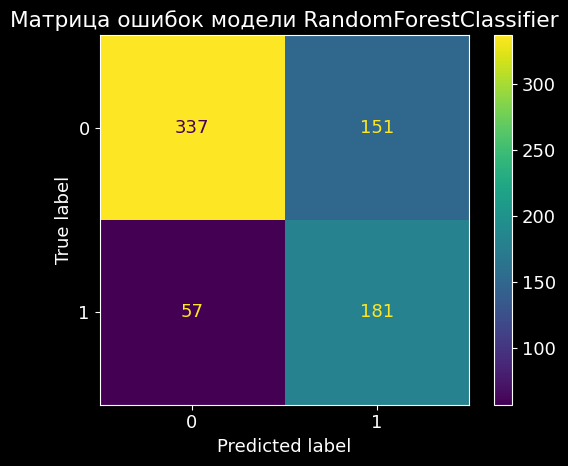

In [ ]:
#визуализируем матрицу ошибок

ConfMatrix(grid_search.best_estimator_)

Видим, что нам удалось добиться улучшения в качестве поиска объектов 1 класса. Это хороший результат

In [ ]:
# оценим важность признаков
importances = grid_search.best_estimator_.feature_importances_
rf_feature_importance = pd.DataFrame({'Importances' : importances * 100,
                                      'Features' : X})

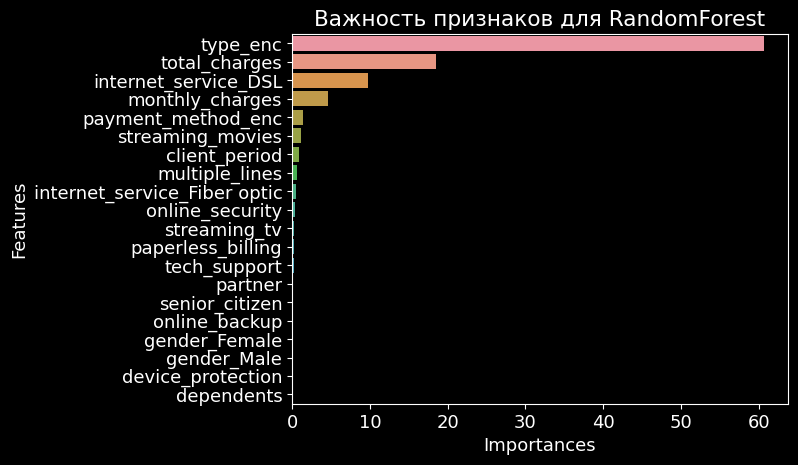

In [ ]:
# построим график
sns.barplot(rf_feature_importance.sort_values(by = 'Importances',
                                              ascending = False),
            x = 'Importances',
            y = 'Features')
plt.title('Важность признаков для RandomForest')
plt.show()

Видим, что randomForest использует мало признаков для предсказаний

### Градиентный бустинг

#### CatBoost

In [ ]:
#инициируем модель
catboost = CatBoostClassifier(random_seed = RANDOM_STATE,
                              verbose = 0)

In [ ]:
#оценим дефолтные значения
scores = cross_val_score(catboost,
                         train[X],
                         train[y],
                         cv = 5,
                         scoring = 'roc_auc')
scores_catboost = scores.mean()
print (f'''Среднее значение roc_auc для модели CatBoost(basic): {scores_catboost:0.4f}''')

Среднее значение roc_auc для модели CatBoost(basic): 0.8113


In [ ]:
#сохраним результат
auc_scores.append({scores_catboost})
models.append('CatBoost(basic)')

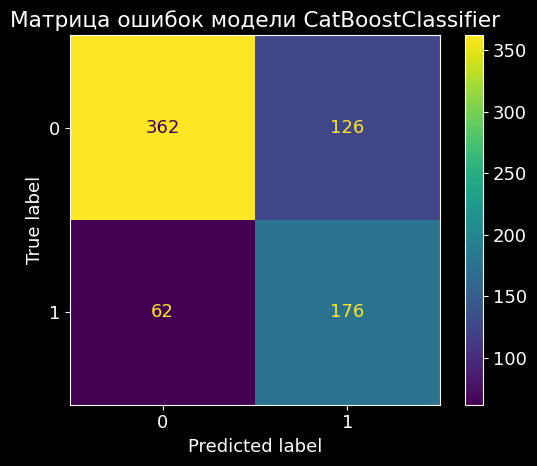

In [ ]:
ConfMatrix(catboost)

На дефолтных параметрах градиентный бустинг дает значения такие же как и randomforest после подбора гиперпараметров:
- первый класс определяет хорошо

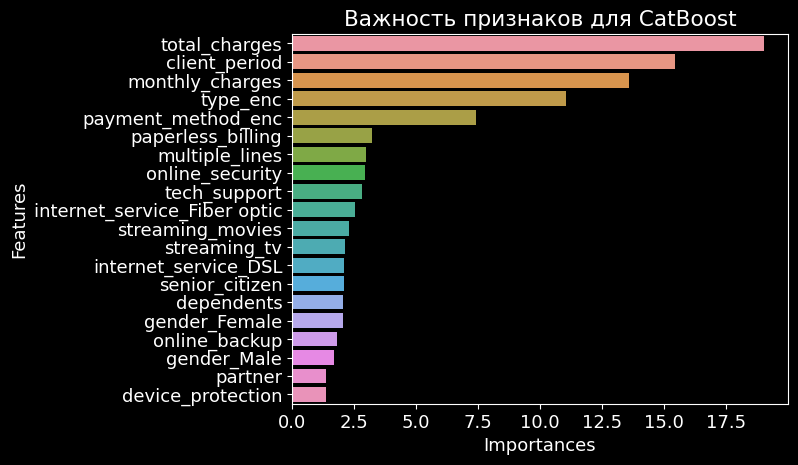

In [ ]:
# проанализируем важность признаков
# обучим модель чтобы извлечь важность признаков
catboost.fit(train[X], train[y], verbose = 0);

catboost_feature_importance = catboost.get_feature_importance(prettified=True)
catboost_feature_importance.columns = ['Features','Importances']
# построим график
sns.barplot(catboost_feature_importance.sort_values(by = 'Importances',ascending = False), x='Importances', y='Features')
plt.title('Важность признаков для CatBoost')
plt.show()

Catboost использует больше признаков, чем random_forest

#### Подбор гиперпараметров

#### Optuna catboost

In [ ]:
# создаем параметры для поиска оптуной
def objective(trial):

    param = {
    'metric': 'auc',
    'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.15),
    'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 1, 9),
    'depth' : trial.suggest_int('depth', 2, 15),
    'class_weight':'balanced'
    }

    clf = catboost = CatBoostClassifier(random_seed = RANDOM_STATE, verbose = 100)

    scores = cross_val_score(clf,
                             train[X],
                             train[y],
                             cv = 3,
                             scoring = 'roc_auc')

    return scores.mean()

In [ ]:
# инициализируем обучение
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 10)

[I 2023-12-20 20:11:19,638] A new study created in memory with name: no-name-eee3cec0-7dc8-4f22-8d75-8b3ced6a62ea


Learning rate set to 0.014779
0:	learn: 0.6860129	total: 3.37ms	remaining: 3.36s
100:	learn: 0.4663696	total: 592ms	remaining: 5.27s
200:	learn: 0.4258687	total: 1.36s	remaining: 5.4s
300:	learn: 0.4026933	total: 2.05s	remaining: 4.75s
400:	learn: 0.3811746	total: 2.68s	remaining: 4s
500:	learn: 0.3621135	total: 3.15s	remaining: 3.14s
600:	learn: 0.3455470	total: 3.57s	remaining: 2.37s
700:	learn: 0.3305605	total: 4.77s	remaining: 2.04s
800:	learn: 0.3166665	total: 5.69s	remaining: 1.41s
900:	learn: 0.3025122	total: 7.02s	remaining: 771ms
999:	learn: 0.2890348	total: 8.25s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6853556	total: 20.6ms	remaining: 20.6s
100:	learn: 0.4668472	total: 1.57s	remaining: 14s
200:	learn: 0.4289010	total: 2.57s	remaining: 10.2s
300:	learn: 0.4045481	total: 3.37s	remaining: 7.83s
400:	learn: 0.3834931	total: 4.03s	remaining: 6.01s
500:	learn: 0.3649878	total: 4.94s	remaining: 4.92s
600:	learn: 0.3476977	total: 6.18s	remaining: 4.1s
700:	learn: 0.3

[I 2023-12-20 20:11:46,981] Trial 0 finished with value: 0.8095075498899765 and parameters: {'learning_rate': 0.12257980177843904, 'l2_leaf_reg': 6, 'depth': 5}. Best is trial 0 with value: 0.8095075498899765.


999:	learn: 0.2910520	total: 9.04s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6860129	total: 7.51ms	remaining: 7.5s
100:	learn: 0.4663696	total: 589ms	remaining: 5.24s
200:	learn: 0.4258687	total: 1.44s	remaining: 5.72s
300:	learn: 0.4026933	total: 2.05s	remaining: 4.75s
400:	learn: 0.3811746	total: 2.59s	remaining: 3.87s
500:	learn: 0.3621135	total: 3.21s	remaining: 3.2s
600:	learn: 0.3455470	total: 3.69s	remaining: 2.45s
700:	learn: 0.3305605	total: 4.14s	remaining: 1.76s
800:	learn: 0.3166665	total: 4.52s	remaining: 1.12s
900:	learn: 0.3025122	total: 5.11s	remaining: 561ms
999:	learn: 0.2890348	total: 5.79s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6853556	total: 2.56ms	remaining: 2.56s
100:	learn: 0.4668472	total: 238ms	remaining: 2.12s
200:	learn: 0.4289010	total: 884ms	remaining: 3.51s
300:	learn: 0.4045481	total: 1.12s	remaining: 2.59s
400:	learn: 0.3834931	total: 1.36s	remaining: 2.04s
500:	learn: 0.3649878	total: 2.01s	remaining: 2s
600:	learn: 0.3

[I 2023-12-20 20:12:02,027] Trial 1 finished with value: 0.8095075498899765 and parameters: {'learning_rate': 0.01981489263830271, 'l2_leaf_reg': 3, 'depth': 6}. Best is trial 0 with value: 0.8095075498899765.


999:	learn: 0.2910520	total: 5.43s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6860129	total: 6.97ms	remaining: 6.97s
100:	learn: 0.4663696	total: 557ms	remaining: 4.96s
200:	learn: 0.4258687	total: 1.17s	remaining: 4.65s
300:	learn: 0.4026933	total: 1.77s	remaining: 4.1s
400:	learn: 0.3811746	total: 2.35s	remaining: 3.51s
500:	learn: 0.3621135	total: 2.78s	remaining: 2.77s
600:	learn: 0.3455470	total: 3.24s	remaining: 2.15s
700:	learn: 0.3305605	total: 3.69s	remaining: 1.57s
800:	learn: 0.3166665	total: 4.5s	remaining: 1.12s
900:	learn: 0.3025122	total: 4.94s	remaining: 543ms
999:	learn: 0.2890348	total: 5.43s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6853556	total: 5.82ms	remaining: 5.82s
100:	learn: 0.4668472	total: 388ms	remaining: 3.46s
200:	learn: 0.4289010	total: 849ms	remaining: 3.37s
300:	learn: 0.4045481	total: 1.23s	remaining: 2.86s
400:	learn: 0.3834931	total: 1.63s	remaining: 2.43s
500:	learn: 0.3649878	total: 2.11s	remaining: 2.1s
600:	learn: 0

[I 2023-12-20 20:12:19,986] Trial 2 finished with value: 0.8095075498899765 and parameters: {'learning_rate': 0.0955016008154964, 'l2_leaf_reg': 3, 'depth': 15}. Best is trial 0 with value: 0.8095075498899765.


999:	learn: 0.2910520	total: 7.29s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6860129	total: 2.58ms	remaining: 2.58s
100:	learn: 0.4663696	total: 294ms	remaining: 2.62s
200:	learn: 0.4258687	total: 574ms	remaining: 2.28s
300:	learn: 0.4026933	total: 875ms	remaining: 2.03s
400:	learn: 0.3811746	total: 1.32s	remaining: 1.97s
500:	learn: 0.3621135	total: 1.59s	remaining: 1.59s
600:	learn: 0.3455470	total: 1.9s	remaining: 1.26s
700:	learn: 0.3305605	total: 2.15s	remaining: 918ms
800:	learn: 0.3166665	total: 2.46s	remaining: 612ms
900:	learn: 0.3025122	total: 2.77s	remaining: 304ms
999:	learn: 0.2890348	total: 3.05s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6853556	total: 3.41ms	remaining: 3.41s
100:	learn: 0.4668472	total: 298ms	remaining: 2.65s
200:	learn: 0.4289010	total: 842ms	remaining: 3.35s
300:	learn: 0.4045481	total: 1.33s	remaining: 3.1s
400:	learn: 0.3834931	total: 1.81s	remaining: 2.7s
500:	learn: 0.3649878	total: 2.14s	remaining: 2.13s
600:	learn: 0

[I 2023-12-20 20:12:32,469] Trial 3 finished with value: 0.8095075498899765 and parameters: {'learning_rate': 0.1206063282778179, 'l2_leaf_reg': 7, 'depth': 7}. Best is trial 0 with value: 0.8095075498899765.


999:	learn: 0.2910520	total: 4.59s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6860129	total: 5.74ms	remaining: 5.74s
100:	learn: 0.4663696	total: 608ms	remaining: 5.41s
200:	learn: 0.4258687	total: 1.48s	remaining: 5.89s
300:	learn: 0.4026933	total: 2.4s	remaining: 5.58s
400:	learn: 0.3811746	total: 3.62s	remaining: 5.41s
500:	learn: 0.3621135	total: 4.96s	remaining: 4.94s
600:	learn: 0.3455470	total: 5.95s	remaining: 3.95s
700:	learn: 0.3305605	total: 7.02s	remaining: 3s
800:	learn: 0.3166665	total: 8.05s	remaining: 2s
900:	learn: 0.3025122	total: 8.95s	remaining: 984ms
999:	learn: 0.2890348	total: 9.8s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6853556	total: 7.34ms	remaining: 7.34s
100:	learn: 0.4668472	total: 415ms	remaining: 3.69s
200:	learn: 0.4289010	total: 868ms	remaining: 3.45s
300:	learn: 0.4045481	total: 1.61s	remaining: 3.73s
400:	learn: 0.3834931	total: 2.64s	remaining: 3.95s
500:	learn: 0.3649878	total: 3.42s	remaining: 3.4s
600:	learn: 0.34769

[I 2023-12-20 20:12:54,729] Trial 4 finished with value: 0.8095075498899765 and parameters: {'learning_rate': 0.005879458684533913, 'l2_leaf_reg': 3, 'depth': 6}. Best is trial 0 with value: 0.8095075498899765.


999:	learn: 0.2910520	total: 4.34s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6860129	total: 2.83ms	remaining: 2.83s
100:	learn: 0.4663696	total: 267ms	remaining: 2.37s
200:	learn: 0.4258687	total: 523ms	remaining: 2.08s
300:	learn: 0.4026933	total: 766ms	remaining: 1.78s
400:	learn: 0.3811746	total: 1s	remaining: 1.5s
500:	learn: 0.3621135	total: 1.24s	remaining: 1.24s
600:	learn: 0.3455470	total: 1.49s	remaining: 992ms
700:	learn: 0.3305605	total: 1.74s	remaining: 742ms
800:	learn: 0.3166665	total: 1.98s	remaining: 491ms
900:	learn: 0.3025122	total: 2.21s	remaining: 243ms
999:	learn: 0.2890348	total: 2.47s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6853556	total: 2.53ms	remaining: 2.53s
100:	learn: 0.4668472	total: 244ms	remaining: 2.17s
200:	learn: 0.4289010	total: 482ms	remaining: 1.92s
300:	learn: 0.4045481	total: 720ms	remaining: 1.67s
400:	learn: 0.3834931	total: 984ms	remaining: 1.47s
500:	learn: 0.3649878	total: 1.23s	remaining: 1.22s
600:	learn: 0.

[I 2023-12-20 20:13:05,346] Trial 5 finished with value: 0.8095075498899765 and parameters: {'learning_rate': 0.016971777267152505, 'l2_leaf_reg': 1, 'depth': 8}. Best is trial 0 with value: 0.8095075498899765.


999:	learn: 0.2910520	total: 5.04s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6860129	total: 2.57ms	remaining: 2.56s
100:	learn: 0.4663696	total: 268ms	remaining: 2.38s
200:	learn: 0.4258687	total: 508ms	remaining: 2.02s
300:	learn: 0.4026933	total: 752ms	remaining: 1.75s
400:	learn: 0.3811746	total: 992ms	remaining: 1.48s
500:	learn: 0.3621135	total: 1.25s	remaining: 1.25s
600:	learn: 0.3455470	total: 1.49s	remaining: 991ms
700:	learn: 0.3305605	total: 1.73s	remaining: 739ms
800:	learn: 0.3166665	total: 1.97s	remaining: 490ms
900:	learn: 0.3025122	total: 2.25s	remaining: 248ms
999:	learn: 0.2890348	total: 2.59s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6853556	total: 5.13ms	remaining: 5.13s
100:	learn: 0.4668472	total: 384ms	remaining: 3.42s
200:	learn: 0.4289010	total: 665ms	remaining: 2.64s
300:	learn: 0.4045481	total: 900ms	remaining: 2.09s
400:	learn: 0.3834931	total: 1.14s	remaining: 1.7s
500:	learn: 0.3649878	total: 1.38s	remaining: 1.38s
600:	learn:

[I 2023-12-20 20:13:21,562] Trial 6 finished with value: 0.8095075498899765 and parameters: {'learning_rate': 0.1484059250453483, 'l2_leaf_reg': 3, 'depth': 13}. Best is trial 0 with value: 0.8095075498899765.


999:	learn: 0.2910520	total: 8.78s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6860129	total: 5.57ms	remaining: 5.56s
100:	learn: 0.4663696	total: 569ms	remaining: 5.07s
200:	learn: 0.4258687	total: 995ms	remaining: 3.95s
300:	learn: 0.4026933	total: 1.47s	remaining: 3.41s
400:	learn: 0.3811746	total: 1.86s	remaining: 2.78s
500:	learn: 0.3621135	total: 2.27s	remaining: 2.26s
600:	learn: 0.3455470	total: 2.86s	remaining: 1.9s
700:	learn: 0.3305605	total: 3.16s	remaining: 1.35s
800:	learn: 0.3166665	total: 3.79s	remaining: 942ms
900:	learn: 0.3025122	total: 4.18s	remaining: 460ms
999:	learn: 0.2890348	total: 4.63s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6853556	total: 6.56ms	remaining: 6.55s
100:	learn: 0.4668472	total: 349ms	remaining: 3.11s
200:	learn: 0.4289010	total: 588ms	remaining: 2.34s
300:	learn: 0.4045481	total: 823ms	remaining: 1.91s
400:	learn: 0.3834931	total: 1.08s	remaining: 1.61s
500:	learn: 0.3649878	total: 1.32s	remaining: 1.31s
600:	learn:

[I 2023-12-20 20:13:32,438] Trial 7 finished with value: 0.8095075498899765 and parameters: {'learning_rate': 0.008795478257406116, 'l2_leaf_reg': 6, 'depth': 8}. Best is trial 0 with value: 0.8095075498899765.


999:	learn: 0.2910520	total: 3.23s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6860129	total: 3.53ms	remaining: 3.52s
100:	learn: 0.4663696	total: 592ms	remaining: 5.27s
200:	learn: 0.4258687	total: 1.07s	remaining: 4.25s
300:	learn: 0.4026933	total: 1.56s	remaining: 3.62s
400:	learn: 0.3811746	total: 1.96s	remaining: 2.93s
500:	learn: 0.3621135	total: 2.46s	remaining: 2.45s
600:	learn: 0.3455470	total: 3s	remaining: 1.99s
700:	learn: 0.3305605	total: 3.42s	remaining: 1.46s
800:	learn: 0.3166665	total: 3.84s	remaining: 955ms
900:	learn: 0.3025122	total: 4.09s	remaining: 449ms
999:	learn: 0.2890348	total: 4.32s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6853556	total: 2.51ms	remaining: 2.51s
100:	learn: 0.4668472	total: 245ms	remaining: 2.18s
200:	learn: 0.4289010	total: 480ms	remaining: 1.91s
300:	learn: 0.4045481	total: 721ms	remaining: 1.67s
400:	learn: 0.3834931	total: 962ms	remaining: 1.44s
500:	learn: 0.3649878	total: 1.22s	remaining: 1.21s
600:	learn: 0

[I 2023-12-20 20:13:42,276] Trial 8 finished with value: 0.8095075498899765 and parameters: {'learning_rate': 0.03883774122809639, 'l2_leaf_reg': 3, 'depth': 2}. Best is trial 0 with value: 0.8095075498899765.


999:	learn: 0.2910520	total: 2.64s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6860129	total: 2.46ms	remaining: 2.46s
100:	learn: 0.4663696	total: 242ms	remaining: 2.15s
200:	learn: 0.4258687	total: 488ms	remaining: 1.94s
300:	learn: 0.4026933	total: 726ms	remaining: 1.69s
400:	learn: 0.3811746	total: 978ms	remaining: 1.46s
500:	learn: 0.3621135	total: 1.22s	remaining: 1.21s
600:	learn: 0.3455470	total: 1.48s	remaining: 982ms
700:	learn: 0.3305605	total: 2.26s	remaining: 964ms
800:	learn: 0.3166665	total: 2.9s	remaining: 722ms
900:	learn: 0.3025122	total: 3.52s	remaining: 386ms
999:	learn: 0.2890348	total: 4.09s	remaining: 0us
Learning rate set to 0.014779
0:	learn: 0.6853556	total: 17.7ms	remaining: 17.7s
100:	learn: 0.4668472	total: 832ms	remaining: 7.41s
200:	learn: 0.4289010	total: 2.14s	remaining: 8.52s
300:	learn: 0.4045481	total: 3.23s	remaining: 7.5s
400:	learn: 0.3834931	total: 4.16s	remaining: 6.21s
500:	learn: 0.3649878	total: 4.95s	remaining: 4.93s
600:	learn: 

[I 2023-12-20 20:13:59,630] Trial 9 finished with value: 0.8095075498899765 and parameters: {'learning_rate': 0.07075391071571467, 'l2_leaf_reg': 3, 'depth': 15}. Best is trial 0 with value: 0.8095075498899765.


999:	learn: 0.2910520	total: 4.75s	remaining: 0us


In [ ]:
# получаем максимальные скор
score_catboost_optuna =  study.best_value
score_catboost_optuna

0.8095075498899765

In [ ]:
# сохраняем лучшие параметры для модели
best_params_catboost = study.best_params
best_params_catboost

{'learning_rate': 0.12257980177843904, 'l2_leaf_reg': 6, 'depth': 5}

In [ ]:
# сохраним результат
auc_scores.append({score_catboost_optuna})
models.append('Catboost(Optuna)')

In [ ]:
# сохраняем модель
catboost_opt = CatBoostClassifier(random_seed = RANDOM_STATE,
                                  verbose = 100,
                                  **best_params_catboost)
catboost_opt.fit(train[X], train[y])

0:	learn: 0.6406737	total: 5.07ms	remaining: 5.07s
100:	learn: 0.3959223	total: 385ms	remaining: 3.42s
200:	learn: 0.3392201	total: 598ms	remaining: 2.38s
300:	learn: 0.2941642	total: 819ms	remaining: 1.9s
400:	learn: 0.2601962	total: 1.04s	remaining: 1.55s
500:	learn: 0.2323641	total: 1.27s	remaining: 1.26s
600:	learn: 0.2091574	total: 1.49s	remaining: 987ms
700:	learn: 0.1881693	total: 1.7s	remaining: 725ms
800:	learn: 0.1694922	total: 1.92s	remaining: 477ms
900:	learn: 0.1535160	total: 2.15s	remaining: 236ms
999:	learn: 0.1403262	total: 2.37s	remaining: 0us


0:	learn: 0.6406737	total: 2.21ms	remaining: 2.21s
100:	learn: 0.3959223	total: 394ms	remaining: 3.51s
200:	learn: 0.3392201	total: 804ms	remaining: 3.2s
300:	learn: 0.2941642	total: 1.25s	remaining: 2.9s
400:	learn: 0.2601962	total: 1.77s	remaining: 2.64s
500:	learn: 0.2323641	total: 2.25s	remaining: 2.24s
600:	learn: 0.2091574	total: 2.67s	remaining: 1.77s
700:	learn: 0.1881693	total: 3.12s	remaining: 1.33s
800:	learn: 0.1694922	total: 3.5s	remaining: 871ms
900:	learn: 0.1535160	total: 3.97s	remaining: 437ms
999:	learn: 0.1403262	total: 4.28s	remaining: 0us


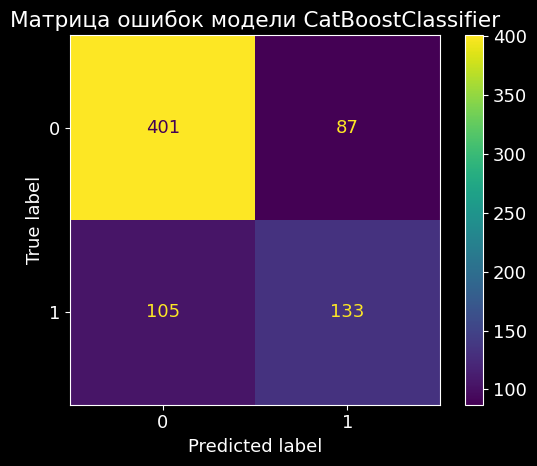

In [ ]:
#визуализируем матрицу ошибок

ConfMatrix(catboost_opt)

#### lightgbm

In [ ]:
# параметры модели
param = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'class_weight':'balanced'}

In [ ]:
# Передаем параметры
lgbm = lgb.LGBMClassifier(**param)


In [ ]:
# получаем скор
scores = cross_val_score(lgbm,
                         train[X],
                         train[y],
                         cv=3,
                         scoring='roc_auc')

lgbm.fit(train[X],  train[y])
scores_lgbm = scores.mean()
print (f'''Среднее значение roc_auc для модели LightGBM: {scores_lgbm}''')

Среднее значение roc_auc для модели LightGBM: 0.7964263556549412


Метрика для этой модели на дефолтных параметрах совсем неудовлетворительная

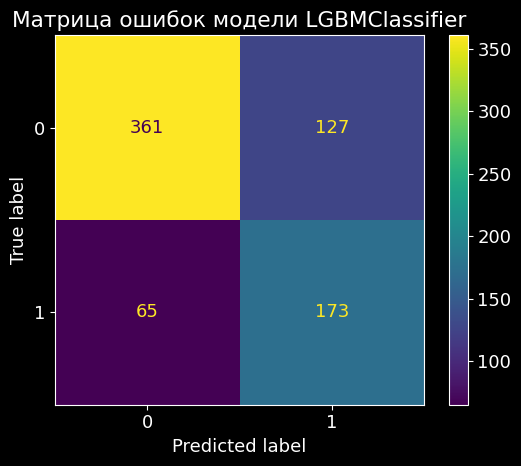

In [ ]:
#визуализируем матрицу ошибок

ConfMatrix(lgbm)

In [ ]:
# сохраним результат
auc_scores.append({scores_lgbm})
models.append('LightGBM(basic)')

#### Подбор гиперпараметров

In [ ]:
# создаем параметры для поиска оптуной
def objective(trial):

    param = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'num_leaves': trial.suggest_int('num_leaves', 32, 256),
    'learning_rate' : trial.suggest_float('learning_rate', 0.0001, 0.1),
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    clf = lgb.LGBMClassifier(**param)  # Передаем параметры как именованные аргументы

    scores = cross_val_score(clf,
                      train[X],
                      train[y],
                      cv=3,
                      scoring='roc_auc')

    return scores.mean()

In [ ]:
# инициализируем обучение
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 100)

[I 2023-12-20 20:14:08,313] A new study created in memory with name: no-name-68676cd1-19d2-4ddf-a2e8-f65c0e847830
[I 2023-12-20 20:14:08,533] Trial 0 finished with value: 0.8216642564150632 and parameters: {'num_leaves': 55, 'learning_rate': 0.08854375592792814, 'boosting_type': 'gbdt', 'lambda_l1': 9.667380738127678, 'lambda_l2': 6.104351251128505, 'bagging_fraction': 0.6281880505374762, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 0 with value: 0.8216642564150632.
[I 2023-12-20 20:14:08,897] Trial 1 finished with value: 0.8206856496297585 and parameters: {'num_leaves': 143, 'learning_rate': 0.07379752874953702, 'boosting_type': 'dart', 'lambda_l1': 4.767806735385933, 'lambda_l2': 6.904016624563374, 'bagging_fraction': 0.7412076722546993, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 0 with value: 0.8216642564150632.
[I 2023-12-20 20:14:09,235] Trial 2 finished with value: 0.8081975335091925 and parameters: {'num_leaves': 125, 'learning_rate': 0.068254647907

In [ ]:
# получаем максимальные скор
score_lgbm_optuna =  study.best_value
score_lgbm_optuna

0.8237146440638629

In [ ]:
# сохраняем лучшие параметры для модели
best_params_lgbm = study.best_params
best_params_lgbm

{'num_leaves': 91,
 'learning_rate': 0.0515136429786292,
 'boosting_type': 'gbdt',
 'lambda_l1': 5.234390702430704,
 'lambda_l2': 8.610954398387129,
 'bagging_fraction': 0.5258000658470643,
 'bagging_freq': 1,
 'min_child_samples': 84}

In [ ]:
# сохраним результат
auc_scores.append({score_lgbm_optuna})
models.append('LightGBM(Optuna)')

In [ ]:
# сохраняем модель
light_gbm_opt = lgb.LGBMClassifier(**best_params_lgbm)
light_gbm_opt.fit(train[X], train[y])

[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.525800065

LGBMClassifier(bagging_fraction=0.5258000658470643, bagging_freq=1,
               lambda_l1=5.234390702430704, lambda_l2=8.610954398387129,
               learning_rate=0.0515136429786292, min_child_samples=84,
               num_leaves=91)

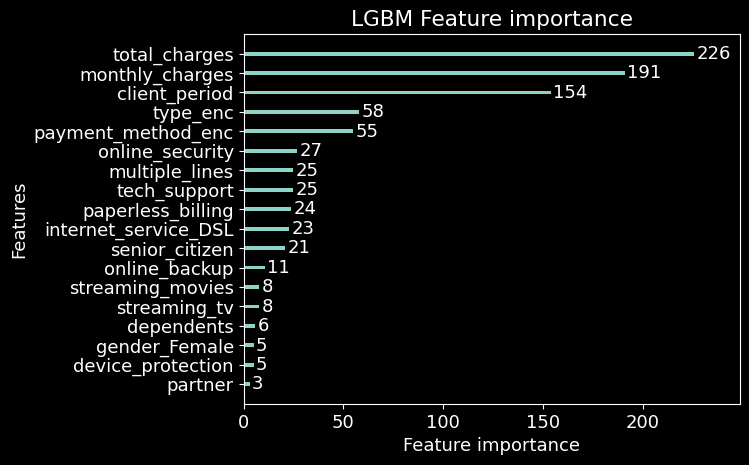

In [ ]:
# оценим важность признаков для этой модели
lgb.plot_importance(light_gbm_opt,
                    height = 0.2,
                    title = 'LGBM Feature importance',
                    xlabel = 'Feature importance',
                    ylabel='Features',
                    importance_type ='auto',
                    grid = False,
                    precision = 3);

In [ ]:
light_gbm_feature_importances = pd.DataFrame({'Importances' : light_gbm_opt.feature_importances_,
                                              'Features' : X}
)


[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.525800065

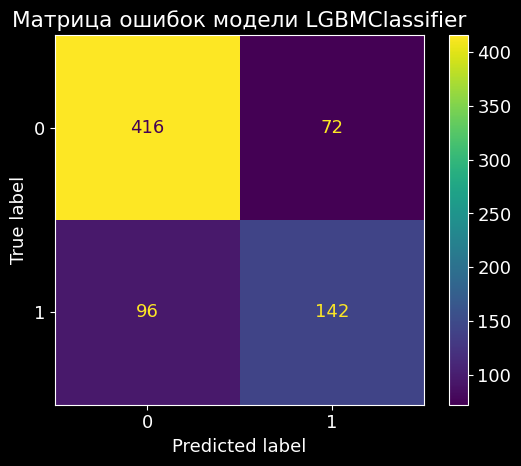

In [ ]:
#визуализируем матрицу ошибок

ConfMatrix(light_gbm_opt)

### Нейронная сеть


In [ ]:
# переводим данные в тензоры
X_train = torch.tensor(train[X].to_numpy(), dtype = torch.float32)
X_valid = torch.tensor(valid[X].to_numpy(), dtype = torch.float32)

y_train = torch.tensor(np.array(train[y]), dtype = torch.float32)
y_valid = torch.tensor(np.array(valid[y]), dtype = torch.float32)

# Проверка размерностей
print(f'''
Train features shape: {X_train.shape}
Train target shape: {y_train.shape}

Valid features shape: {X_valid.shape}
Valid target shape: {y_valid.shape}''')


Train features shape: torch.Size([3492, 20])
Train target shape: torch.Size([3492])

Valid features shape: torch.Size([726, 20])
Valid target shape: torch.Size([726])


In [ ]:
# инициируем полносвязную нейронную сеть с дропаутом
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob = 0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Dropout(p = dropout_prob))

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Dropout(p=dropout_prob)
            )


        self.fc3 = nn.Sequential(
            nn.Linear(hidden_size2, output_size),
            nn.Sigmoid()
            )


    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


In [ ]:
# Параметры нейронной сети
input_size = 20  # Размер входных данных
hidden_size1 = 128  # Размер скрытого слоя
hidden_size2 = 512
output_size = 1

In [ ]:
# Инициализация нейронной сети, функции потерь и оптимизатора
model = SimpleNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.BCELoss()  # Бинарная кросс-энтропия
optimizer = optim.SGD(model.parameters(), lr = 0.01)

# выведем архитектуру модели
summary(model , input_size = (X_train.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           2,688
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                  [-1, 512]          66,048
              ReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                    [-1, 1]             513
           Sigmoid-8                    [-1, 1]               0
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.26
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


In [ ]:
# Обучение нейронной сети
num_epochs = 2500
for epoch in range(num_epochs):

    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# получаем предсказания
with torch.no_grad():
    model.eval()
    predictions = model(X_valid)
    probabilities = predictions.numpy()# вероятности принадлежности к классу 1

Epoch [100/2500], Loss: 0.5954
Epoch [200/2500], Loss: 0.5673
Epoch [300/2500], Loss: 0.5515
Epoch [400/2500], Loss: 0.5331
Epoch [500/2500], Loss: 0.5289
Epoch [600/2500], Loss: 0.5258
Epoch [700/2500], Loss: 0.5186
Epoch [800/2500], Loss: 0.5148
Epoch [900/2500], Loss: 0.5139
Epoch [1000/2500], Loss: 0.5138
Epoch [1100/2500], Loss: 0.5172
Epoch [1200/2500], Loss: 0.5094
Epoch [1300/2500], Loss: 0.5103
Epoch [1400/2500], Loss: 0.5140
Epoch [1500/2500], Loss: 0.5096
Epoch [1600/2500], Loss: 0.5074
Epoch [1700/2500], Loss: 0.5034
Epoch [1800/2500], Loss: 0.5076
Epoch [1900/2500], Loss: 0.5064
Epoch [2000/2500], Loss: 0.5062
Epoch [2100/2500], Loss: 0.5021
Epoch [2200/2500], Loss: 0.5019
Epoch [2300/2500], Loss: 0.5045
Epoch [2400/2500], Loss: 0.5037
Epoch [2500/2500], Loss: 0.5010


In [ ]:
# переведем вероятности в метки классов
preds = (probabilities > 0.5).astype('int')

# посчитаем метрику roc_auc
simple_nn_auc = roc_auc_score(y_valid, probabilities)
simple_nn_auc

0.8097620195619231

In [ ]:
# сохраним результат
auc_scores.append({simple_nn_auc})
models.append('Neural Net with dropout')

### Сравнительный анализ работы моделей


In [ ]:
# отобразим все результаты в датафрейме
result_origin = pd.DataFrame({'model': models,
                              'roc_auc_score' : auc_scores})

result_origin

,model,roc_auc_score
0,RandomForest(basic),0.803077
1,RandomForest(grid_search),{0.8154546597453762}
2,CatBoost(basic),{0.8113388946252513}
3,Catboost(Optuna),{0.8095075498899765}
4,LightGBM(basic),{0.7964263556549412}
5,LightGBM(Optuna),{0.8237146440638629}
6,Neural Net with dropout,{0.8097620195619231}


In [ ]:
all_models = [random_forest, random_forest_gs, catboost,  catboost_opt, lgbm, light_gbm_opt]
all_models

[RandomForestClassifier(class_weight='balanced', random_state=11122023),
 RandomForestClassifier(class_weight='balanced', max_depth=55, max_features=None,
                        min_samples_leaf=88, min_samples_split=74,
                        n_estimators=301, random_state=11122023),
 LGBMClassifier(class_weight='balanced', metric='binary_logloss',
                objective='binary', verbosity=-1),
 LGBMClassifier(bagging_fraction=0.5258000658470643, bagging_freq=1,
                lambda_l1=5.234390702430704, lambda_l2=8.610954398387129,
                learning_rate=0.0515136429786292, min_child_samples=84,
                num_leaves=91)]

[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


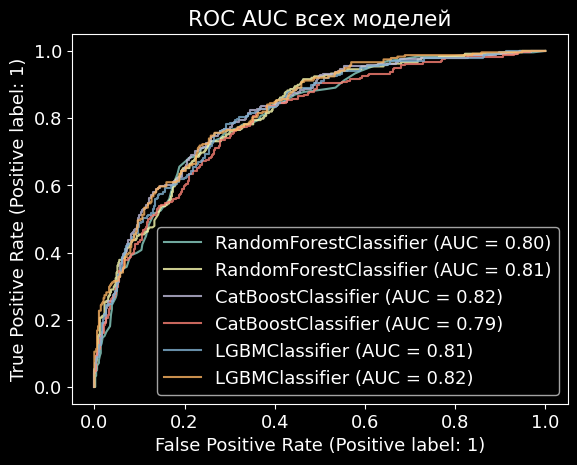

In [ ]:
AucDisp(all_models)

Видим, что все кривые примерно одинаковы и

На основе проделанной работы нам не удалось достичь требуемых показателей roc auc score, вместо требуемого уровня 0.85 мы имеем только 0.82.
Мной были использованы следующие модели:
- RandomForest
- CatBoost
- LightGBM
- Полносвязная нейронная сеть с дропаутом.
Для каждой модели я подбирала гиперпараметры, но метрику улучшить до требуемого значения так и не удалось.
В результате лучший результ показали 3 модели:

|Модель | Значение метрики |
|---------------------|-------|
|  RandomForest       | 0.8154  
|   LightGBM          | 0.8215
| Neural net          | 0.8113

CatBoost показал результаты хуже других, что удивительно, оптимизация гиперпараметров несущественно повлияла.

# Генерация новых признаков

Объединим все значения важности признаков и найдем самые важные признаки для моделей, чтобы на их основе составить новые

In [ ]:
important_features = pd.concat([
    rf_feature_importance.sort_values(by ='Importances', ascending = False).head(10),
    catboost_feature_importance.sort_values(by ='Importances', ascending = False).head(10),
    light_gbm_feature_importances.sort_values(by = 'Importances', ascending = False).head(10)])\
                    .groupby('Features')['Importances'].sum()
# выведем признаки с наибольшей важностью для всех моделей
important_features.sort_values(ascending = False)

Features
total_charges                   263.549571
monthly_charges                 209.198935
client_period                   170.411511
type_enc                        129.780664
payment_method_enc               63.838971
internet_service_DSL             32.733506
online_security                  30.351564
multiple_lines                   28.586946
tech_support                     27.832179
paperless_billing                27.224376
internet_service_Fiber optic      3.046674
streaming_movies                  1.148711
Name: Importances, dtype: float64

На основе самых важных исходных признаков составим новые:
- total_services: сумма всех услуг клиента
- mean_monthly_spending: средниие траты в месяц
- service_per_period: сколько сервисом клиент оформил за период



In [ ]:
train.columns

Index(['paperless_billing', 'monthly_charges', 'total_charges',
       'senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'churn', 'internet_service_DSL',
       'internet_service_Fiber optic', 'gender_Female', 'gender_Male',
       'client_period', 'type_enc', 'payment_method_enc'],
      dtype='object')

In [ ]:
# функция для создания новых признаков
def make_new_data(data):

    data = data.copy()

    #признаки на основе которых получим total_services
    columns_to_sum = ['online_security',
                      'online_backup',
                      'device_protection',
                      'tech_support',
                      'streaming_tv',
                      'streaming_movies',
                      'multiple_lines',
                      'internet_service_DSL',
                      'internet_service_Fiber optic']
     # 1
    data['total_services'] = data[columns_to_sum].sum(axis = 1)
    # заменим нулевые значения чтобы не было ошибок при делении
    data.loc[data['total_services'] == 0, 'total_services'] = data.loc[data['total_services'] == 0, 'total_services'] = 0.01

    data.loc[data['client_period'] == 0, 'client_period'] = data.loc[data['client_period'] == 0, 'client_period'] = 0.01
    # 2
    #считаем среднее значение месячных трат
    data['mean_monthly_spending'] = data['monthly_charges'] / (data['client_period']/30)
     # заменим нулевые значения чтобы не было ошибок при делении
    data.loc[data['total_charges'] == 0, 'total_charges'] = data.loc[data['total_charges'] == 0, 'total_charges'] = 0.01

    # 3
    # сколько серввисом оформили за весь период
    data['cost_per_service'] = data['total_services'] / data['total_charges']


    return data

In [ ]:
train_new = make_new_data(train)
valid_new = make_new_data(valid)
test_new = make_new_data(test)

In [ ]:
# масштабируем
to_transform = ['total_services','mean_monthly_spending', 'cost_per_service']

train_new[to_transform] =  scaler.fit_transform(train_new[to_transform])
valid_new[to_transform] = scaler.transform(valid_new[to_transform])
test_new[to_transform] = scaler.transform(test_new[to_transform])

train_new.head()

,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,internet_service_DSL,internet_service_Fiber optic,gender_Female,gender_Male,client_period,type_enc,payment_method_enc,total_services,mean_monthly_spending,cost_per_service
2539,0.661982,-0.643630,0.319251,-0.505185,1.00632,-0.59852,-0.748081,-0.895984,-0.884614,-0.763515,...,1.337586,-1.337586,1.010363,-1.010363,0.608795,-0.970732,-0.954282,-0.106013,-0.057618,-0.099747
3990,0.661982,1.515296,2.066399,1.979472,1.00632,-0.59852,-0.748081,1.116091,1.130436,1.309731,...,-0.747615,0.747615,-0.989743,0.989743,0.016087,-1.509997,-0.958571,1.479665,4.942906,0.011397
3306,0.661982,-0.384668,-0.118359,1.979472,-0.99372,-0.59852,-0.748081,-0.895984,-0.884614,-0.763515,...,-0.747615,0.747615,1.010363,-1.010363,0.560411,0.790112,-0.958571,-1.145848,-0.038151,0.962047
4266,0.661982,0.888335,-0.987966,1.979472,-0.99372,-0.59852,-0.748081,1.116091,-0.884614,-0.763515,...,-0.747615,0.747615,1.010363,-1.010363,-1.399156,0.790112,1.179567,0.416988,-0.035448,-0.109290
3535,0.661982,1.883295,1.424216,1.979472,-0.99372,-0.59852,1.336754,1.116091,1.130436,1.309731,...,-0.747615,0.747615,-0.989743,0.989743,-0.419373,0.790112,1.179567,2.021578,-0.237867,0.085982


In [ ]:
X_new = train_new.drop('churn', axis = 1).columns.to_list()
y_new = 'churn'

In [ ]:
light_gbm_opt.fit(train_new[X_new], train[y_new])

[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.525800065

LGBMClassifier(bagging_fraction=0.5258000658470643, bagging_freq=1,
               lambda_l1=5.234390702430704, lambda_l2=8.610954398387129,
               learning_rate=0.0515136429786292, min_child_samples=84,
               num_leaves=91)

In [ ]:
#оценим дефолтные значения
scores = cross_val_score(light_gbm_opt,
                         train_new[X_new],
                         train_new[y_new],
                         cv = 5,
                         scoring = 'roc_auc')
scores_lgbm_new = scores.mean()
print (f'''Среднее значение roc_auc для модели LightGbm(new features): {scores_lgbm_new : 0.4f}''')

[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.525800065

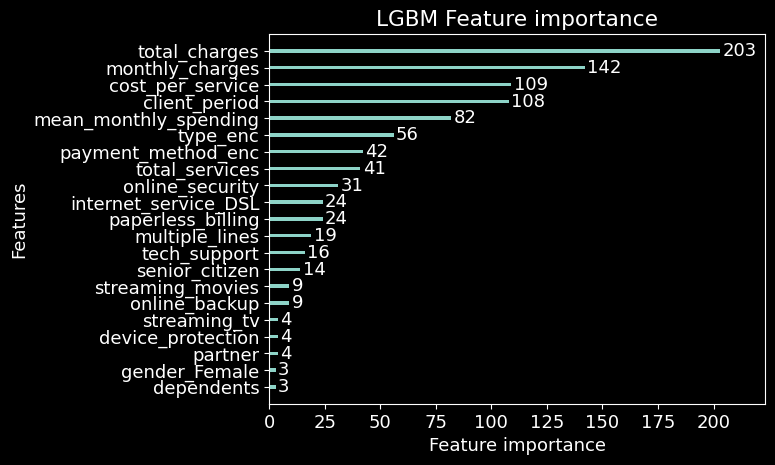

In [ ]:
# оценим важность признаков для этой модели
lgb.plot_importance(light_gbm_opt,
                    height = 0.2,
                    title = 'LGBM Feature importance',
                    xlabel = 'Feature importance',
                    ylabel='Features',
                    importance_type ='auto',
                    grid = False,
                    precision = 3);

In [ ]:
lgbm = light_gbm_opt.fit(train_new[X_new],
                         train_new[y_new])

[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.525800065

In [ ]:
preds = lgbm.predict_proba(valid_new[X_new])[:,1]
preds.shape

[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


(726,)

In [ ]:
# посмотрим результат
roc_auc_score(y_valid.numpy(), preds)

0.8201758162281305

In [ ]:
# создаем параметры для поиска оптуной
def objective(trial):

    param = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'num_leaves': trial.suggest_int('num_leaves', 32, 256),
    'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.1),
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    clf = lgb.LGBMClassifier(**param)  # Передаем параметры как именованные аргументы

    scores = cross_val_score(clf,
                      train_new[X],
                      train_new[y],
                      cv=3,
                      scoring='roc_auc')

    return scores.mean()
# инициализируем обучение
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 100)

[I 2023-12-20 20:17:25,202] A new study created in memory with name: no-name-602a0dc0-769c-4f2d-bf2c-990f682e23b2
[I 2023-12-20 20:17:25,527] Trial 0 finished with value: 0.8178820583548694 and parameters: {'num_leaves': 178, 'learning_rate': 0.04584483672281406, 'boosting_type': 'dart', 'lambda_l1': 9.150864353100232, 'lambda_l2': 2.609963351429773, 'bagging_fraction': 0.40602071024127995, 'bagging_freq': 4, 'min_child_samples': 74}. Best is trial 0 with value: 0.8178820583548694.
[I 2023-12-20 20:17:25,698] Trial 1 finished with value: 0.7957691157501016 and parameters: {'num_leaves': 147, 'learning_rate': 0.08381509517854464, 'boosting_type': 'rf', 'lambda_l1': 3.985447966455746, 'lambda_l2': 7.775861724142903, 'bagging_fraction': 0.5514874116281006, 'bagging_freq': 3, 'min_child_samples': 93}. Best is trial 0 with value: 0.8178820583548694.
[I 2023-12-20 20:17:25,991] Trial 2 finished with value: 0.8164018737474503 and parameters: {'num_leaves': 129, 'learning_rate': 0.013562682751

In [ ]:
study.best_value

0.8254648661194505

На новых признаках результат хуже чем на исходных.

Таким образом мы получили лучшую модель:
- LightGBM на гиперпараметрах
    - 'num_leaves': 115,
    - 'learning_rate': 0.04383151107998701,
    - 'boosting_type': 'gbdt',
    - 'lambda_l1': 3.3780247695785626,
    - 'lambda_l2': 5.369456836045817,
    - 'bagging_fraction': 0.4554306729469965,
    - 'bagging_freq': 4,
    -  'min_child_samples': 63

Именно эту модель будем тестировать на тестовой выборке.

## Тестирование лучшей модели

In [ ]:
best_model = light_gbm_opt

In [ ]:
# объединим выборки для обучения финальной модели
train_concat =  pd.concat([train, valid], axis = 0)
train_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 2539 to 850
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   paperless_billing             4218 non-null   float64
 1   monthly_charges               4218 non-null   float64
 2   total_charges                 4218 non-null   float64
 3   senior_citizen                4218 non-null   float64
 4   partner                       4218 non-null   float64
 5   dependents                    4218 non-null   float64
 6   online_security               4218 non-null   float64
 7   online_backup                 4218 non-null   float64
 8   device_protection             4218 non-null   float64
 9   tech_support                  4218 non-null   float64
 10  streaming_tv                  4218 non-null   float64
 11  streaming_movies              4218 non-null   float64
 12  multiple_lines                4218 non-null   float64
 13  c

In [ ]:
best_model.fit(train_concat[X], train_concat[y])

[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.525800065

LGBMClassifier(bagging_fraction=0.5258000658470643, bagging_freq=1,
               lambda_l1=5.234390702430704, lambda_l2=8.610954398387129,
               learning_rate=0.0515136429786292, min_child_samples=84,
               num_leaves=91)

In [ ]:
test_preds = best_model.predict_proba(test[X])

[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [ ]:
roc_auc_score(test[y], test_preds[:,1])

0.8201717762137659

In [ ]:
y_test = (test_preds[:,1] > 0.5).astype('int')

[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.525800065

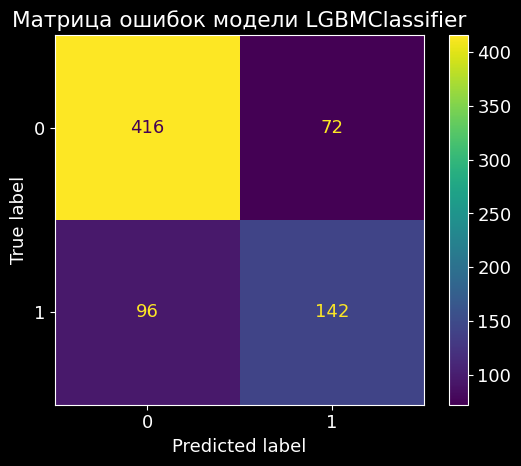

In [ ]:
#визуализируем матрицу ошибок

ConfMatrix(best_model)

[LightGBM] [Warning] lambda_l2 is set=8.610954398387129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.610954398387129
[LightGBM] [Warning] lambda_l1 is set=5.234390702430704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.234390702430704
[LightGBM] [Warning] bagging_fraction is set=0.5258000658470643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5258000658470643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


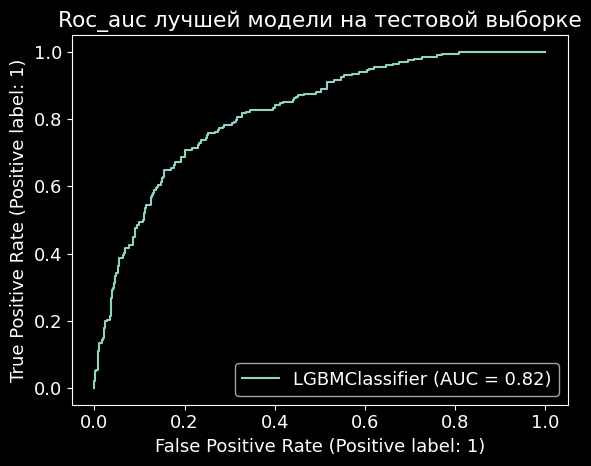

In [ ]:
RocCurveDisplay.from_estimator(best_model,
                               test[X],
                               test[y])

plt.title('Roc_auc лучшей модели на тестовой выборке')
plt.show()

На тестовой выборке метрика roc_auc сопоставима с метрикой на train выборке.


In [ ]:
# отобразим
precision, recall, _ = precision_recall_curve(test[y], y_test)

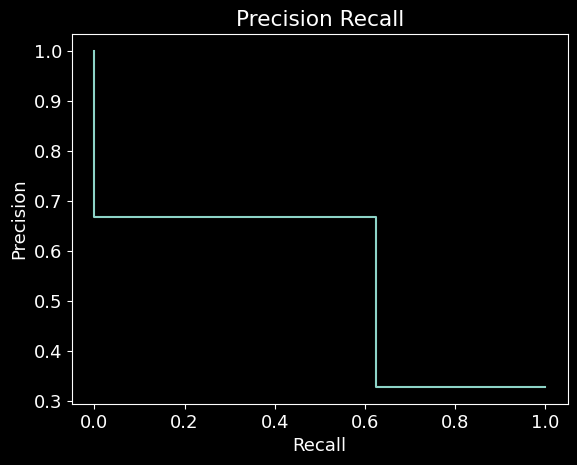

In [ ]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title('Precision Recall')
plt.show()

Несмотря на низкую метрику roc auc score мы видим, что предсказания модели сбалансированы, нет сильного перекоса ни в сторону precision ни в сторону recall. Учитывая дисбаланс классов (80/20) я считаю это важным, так как наша основная задача находить положительный класс, и, учитывая что 0 класс это 80 % выборки, увеличивать roc auc за счет роста precision представляется мне нецелесообразным.

## Вывод

В результате проведенного исследования мной была проделана следующая работа и достигнуты результаты:
- Загружены данные из базы данных методом inner, по колонке user_id.
В результате объединения, около 2,5 тыс данных потерялись, и итоговый датасет содерждал 4835 объектов и 20 признаков.
Названия признаков были перезаписаны в snake_case (изначально были в camel case).
-Анализ и предобработка выявили что в данных в признаках total_charges данные для новых клиентов обратились в Nan, поэтому я заменила эти пропуски значением 0. Так же имелись пропущенные значения в признаке end date. В этом признаке я пропуски не заполняла, а создала новый признак churn, который являлся целевым в моем исследовании, и значения с пропусками соответствовали объектам с 0, т.е. те у кого в графе end_date не было значения.
Далее было выявлено, что почти все признаки это булев тип, но записаны категориями, поэтому я заменила все признаки содержащие 2 уникальные категории на 0 и 1. После этого в данных осталось всего 2 признака, который являлся категориальным type, payment_method
- В данных отсутствуют аномальные значения, дупликаты.
- На основе признаков begin_date и end date был создан признак client_period, а исходные признаки были удалены чтобы избежать утечку данных.

**Машинное обучение**
Для того, чтобы передать наши данные в модели мл, я провела следующую подготовку:
- разделила выборку на train, valid и test (70/15/15).
- перекодировала признаки type, payment_method. Кодировала с помощью среднего значения целевого признака для каждого уникального значения в признаке.
- масштабировала признаки с помощью standard_scaler (хотя можно было и не делать, но иначе мы не смогли бы исопльзовать нейронную сеть)

В результате мной были получены следующие результаты:

|model |roc_auc_score|
|----|-----|
| RandomForest(basic)| 0.803077  
|RandomForest(grid_search)| 0.8154546597453762
|CatBoost(basic)|0.8113388946252513
|Catboost(Optuna)|0.8095075498899765
|LightGBM(basic)|0.7964263556549412
|LightGBM(Optuna)|0.8250358190168852
|Neural Net with dropout|0.8159181705469073

Для всех моделей подбирались гиперпараметры (кроме нейросети). Способ подбора гиперпараметров указан в скобках. Таким образом, лучший результат был достигнут моделью LightGBM, использующий gradient descent алгоритм.

Далее мной была предпринята попытка создать новые признаки на основе самых важных для моделей и были созданы 3 новых признака:
- total_services: сумма всех услуг клиента
- mean_monthly_spending: средниие траты в месяц
- service_per_period: сколько сервисом клиент оформил за период
 Но на этих данных модель показала хуже (хоть и незначительно) результат.

 Итоговое тестирование модели на test выборке было проведено моделью lightGbm c параметрами
- 'num_leaves': 203,
-  'learning_rate': 0.07363008988636893,
-  'boosting_type': 'gbdt',
-  'lambda_l1': 7.119095487843003,
-  'lambda_l2': 9.525521905551784,
-  'bagging_fraction': 0.4494637058926308,
-  'bagging_freq': 4,
-  'min_child_samples': 89.